In [4]:
import numerox as nx

nx.data.TRAIN_FILE = 'numerai_training_data.csv'
nx.data.TOURNAMENT_FILE = 'numerai_tournament_data.csv' 
 
data = nx.download('nr.zip')



nr.zip:   0%|                                                                                                             | 0.00/154M [00:00<?, ?B/s]

nr.zip:   0%|                                                                                                  | 1.02k/154M [00:00<5:57:26, 7.17kB/s]

nr.zip:   0%|                                                                                                  | 17.4k/154M [00:00<4:17:01, 9.97kB/s]

nr.zip:   0%|                                                                                                  | 34.8k/154M [00:00<3:06:17, 13.8kB/s]

nr.zip:   0%|                                                                                                  | 68.6k/154M [00:00<2:13:41, 19.2kB/s]

nr.zip:   0%|                                                                                                  | 87.0k/154M [00:00<1:39:38, 25.7kB/s]

nr.zip:   0%|                                                                               

In [170]:
data

region    train, validation, test, live
rows      836711
era       181, [era1, eraX]
x         50, min 0.0000, mean 0.5026, max 1.0000
y         mean 0.499616, fraction missing 0.3321

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras import regularizers


C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [8]:
import numpy as np
from sklearn.model_selection import train_test_split

In [9]:
%%time

from pipe import *

eras_distinct = set(data.era) | as_list 

era_data = eras    \
        | select( lambda e: np.logical_and( data.region=='train', data.era==e ) ) \
        | select( lambda e: ( data.x[ e ], data.y[3][e] ) ) \
        | where( lambda e: e[0].shape[0] > 0 ) \
        | select( lambda e: train_test_split( e[0], e[1], test_size=0.33  ) ) \
        | as_list()

Wall time: 1min 19s


In [10]:
eras = list( data.era[data.region=='train'] ) | select( lambda e: int( e.replace('era','') ) ) | as_list

from keras.utils import to_categorical

eras_y = to_categorical(eras)

First build the era-predicting model

In [11]:
import matplotlib.pyplot as plt

def plot(history, val=True, train=True, title='Bernie', metric='loss'):
    if train:
        plt.plot(history.history[metric][2:])
    if val:
        plt.plot(history.history['val_%s' % (metric) ][2:])
        
    plt.title('model %s on %s!' %(metric, title))
    plt.ylabel(metric)
    plt.xlabel('epoch')
    
    labels = []
    if train: 
        labels.append('train')
    if val: 
        labels.append('validation')
        
    plt.legend(labels, loc='upper left')
    plt.show()

In [ ]:
%%time

from keras.callbacks import EarlyStopping

Xtrain, Xtest, Ytrain, Ytest = train_test_split( data.x[ data.region=='train' ], eras_y, test_size=0.5 )

model_dense = Sequential([
    Dense(32, input_shape=(50,)),
    Activation('relu'),
    Dropout(0.3),
    Dense(100),
    Activation('relu'),
    Dense(100),
    Activation('relu'),
    Dropout(0.3),
    Dense(100),
    Dropout(0.3),
    Activation('relu'),
    Dense(100),
    Activation('relu'),
    Dense(100),
    Activation('relu'),
    Dropout(0.3),
    Dense(121),
    Activation('softmax'),
])

model_dense.summary()

model_dense.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_crossentropy','acc'])

callbacks = [EarlyStopping(monitor='val_loss', 
              min_delta=0, 
              patience=100, 
              verbose=0, 
              mode='auto', 
              baseline=None, 
              restore_best_weights=True)]

history = model_dense.fit(Xtrain, 
                    Ytrain, 
                    validation_data=(Xtest,Ytest), 
                    epochs=3000, 
                    callbacks=callbacks,
                    batch_size=10000, 
                    shuffle=True)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_502 (Dense)            (None, 32)                1632      
_________________________________________________________________
activation_502 (Activation)  (None, 32)                0         
_________________________________________________________________
dropout_253 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_503 (Dense)            (None, 100)               3300      
_________________________________________________________________
activation_503 (Activation)  (None, 100)               0         
_________________________________________________________________
dense_504 (Dense)            (None, 100)               10100     
_________________________________________________________________
activation_504 (Activation)  (None, 100)               0         
__________

251366/251366 [==============================] - ETA: 0s - loss: 4.7812 - categorical_crossentropy: 4.7812 - acc: 0.00 - ETA: 0s - loss: 4.7809 - categorical_crossentropy: 4.7809 - acc: 0.00 - ETA: 0s - loss: 4.7806 - categorical_crossentropy: 4.7806 - acc: 0.00 - ETA: 0s - loss: 4.7809 - categorical_crossentropy: 4.7809 - acc: 0.00 - ETA: 0s - loss: 4.7810 - categorical_crossentropy: 4.7810 - acc: 0.00 - ETA: 0s - loss: 4.7811 - categorical_crossentropy: 4.7811 - acc: 0.00 - ETA: 0s - loss: 4.7810 - categorical_crossentropy: 4.7810 - acc: 0.00 - ETA: 0s - loss: 4.7812 - categorical_crossentropy: 4.7812 - acc: 0.00 - ETA: 0s - loss: 4.7813 - categorical_crossentropy: 4.7813 - acc: 0.00 - 1s 4us/step - loss: 4.7813 - categorical_crossentropy: 4.7813 - acc: 0.0092 - val_loss: 4.7798 - val_categorical_crossentropy: 4.7798 - val_acc: 0.0098
Epoch 8/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7803 - categorical_crossentropy: 4.7803 - acc: 0.01 - ETA: 0s - loss: 4

251366/251366 [==============================] - ETA: 0s - loss: 4.7766 - categorical_crossentropy: 4.7766 - acc: 0.01 - ETA: 0s - loss: 4.7769 - categorical_crossentropy: 4.7769 - acc: 0.01 - ETA: 0s - loss: 4.7765 - categorical_crossentropy: 4.7765 - acc: 0.01 - ETA: 0s - loss: 4.7761 - categorical_crossentropy: 4.7761 - acc: 0.01 - ETA: 0s - loss: 4.7764 - categorical_crossentropy: 4.7764 - acc: 0.01 - ETA: 0s - loss: 4.7763 - categorical_crossentropy: 4.7763 - acc: 0.01 - ETA: 0s - loss: 4.7762 - categorical_crossentropy: 4.7762 - acc: 0.01 - ETA: 0s - loss: 4.7761 - categorical_crossentropy: 4.7761 - acc: 0.01 - ETA: 0s - loss: 4.7762 - categorical_crossentropy: 4.7762 - acc: 0.01 - 1s 4us/step - loss: 4.7762 - categorical_crossentropy: 4.7762 - acc: 0.0105 - val_loss: 4.7736 - val_categorical_crossentropy: 4.7736 - val_acc: 0.0102
Epoch 17/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7726 - categorical_crossentropy: 4.7726 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7712 - categorical_crossentropy: 4.7712 - acc: 0.01 - ETA: 0s - loss: 4.7721 - categorical_crossentropy: 4.7721 - acc: 0.01 - ETA: 0s - loss: 4.7724 - categorical_crossentropy: 4.7724 - acc: 0.01 - ETA: 0s - loss: 4.7726 - categorical_crossentropy: 4.7726 - acc: 0.01 - ETA: 0s - loss: 4.7723 - categorical_crossentropy: 4.7723 - acc: 0.01 - ETA: 0s - loss: 4.7721 - categorical_crossentropy: 4.7721 - acc: 0.01 - ETA: 0s - loss: 4.7720 - categorical_crossentropy: 4.7720 - acc: 0.01 - ETA: 0s - loss: 4.7719 - categorical_crossentropy: 4.7719 - acc: 0.01 - ETA: 0s - loss: 4.7718 - categorical_crossentropy: 4.7718 - acc: 0.01 - 1s 4us/step - loss: 4.7718 - categorical_crossentropy: 4.7718 - acc: 0.0108 - val_loss: 4.7686 - val_categorical_crossentropy: 4.7686 - val_acc: 0.0104
Epoch 26/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7704 - categorical_crossentropy: 4.7704 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7684 - categorical_crossentropy: 4.7684 - acc: 0.00 - ETA: 0s - loss: 4.7670 - categorical_crossentropy: 4.7670 - acc: 0.01 - ETA: 0s - loss: 4.7673 - categorical_crossentropy: 4.7673 - acc: 0.01 - ETA: 0s - loss: 4.7675 - categorical_crossentropy: 4.7675 - acc: 0.01 - ETA: 0s - loss: 4.7676 - categorical_crossentropy: 4.7676 - acc: 0.01 - ETA: 0s - loss: 4.7679 - categorical_crossentropy: 4.7679 - acc: 0.01 - ETA: 0s - loss: 4.7683 - categorical_crossentropy: 4.7683 - acc: 0.01 - ETA: 0s - loss: 4.7685 - categorical_crossentropy: 4.7685 - acc: 0.01 - ETA: 0s - loss: 4.7686 - categorical_crossentropy: 4.7686 - acc: 0.01 - 1s 4us/step - loss: 4.7686 - categorical_crossentropy: 4.7686 - acc: 0.0108 - val_loss: 4.7669 - val_categorical_crossentropy: 4.7669 - val_acc: 0.0105
Epoch 35/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7684 - categorical_crossentropy: 4.7684 - acc: 0.00 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7625 - categorical_crossentropy: 4.7625 - acc: 0.01 - ETA: 0s - loss: 4.7650 - categorical_crossentropy: 4.7650 - acc: 0.01 - ETA: 0s - loss: 4.7647 - categorical_crossentropy: 4.7647 - acc: 0.01 - ETA: 0s - loss: 4.7654 - categorical_crossentropy: 4.7654 - acc: 0.01 - ETA: 0s - loss: 4.7657 - categorical_crossentropy: 4.7657 - acc: 0.01 - ETA: 0s - loss: 4.7657 - categorical_crossentropy: 4.7657 - acc: 0.01 - ETA: 0s - loss: 4.7658 - categorical_crossentropy: 4.7658 - acc: 0.01 - ETA: 0s - loss: 4.7659 - categorical_crossentropy: 4.7659 - acc: 0.01 - ETA: 0s - loss: 4.7660 - categorical_crossentropy: 4.7660 - acc: 0.01 - 1s 4us/step - loss: 4.7660 - categorical_crossentropy: 4.7660 - acc: 0.0113 - val_loss: 4.7636 - val_categorical_crossentropy: 4.7636 - val_acc: 0.0112
Epoch 44/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7617 - categorical_crossentropy: 4.7617 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7590 - categorical_crossentropy: 4.7590 - acc: 0.01 - ETA: 0s - loss: 4.7622 - categorical_crossentropy: 4.7622 - acc: 0.01 - ETA: 0s - loss: 4.7627 - categorical_crossentropy: 4.7627 - acc: 0.01 - ETA: 0s - loss: 4.7625 - categorical_crossentropy: 4.7625 - acc: 0.01 - ETA: 0s - loss: 4.7628 - categorical_crossentropy: 4.7628 - acc: 0.01 - ETA: 0s - loss: 4.7624 - categorical_crossentropy: 4.7624 - acc: 0.01 - ETA: 0s - loss: 4.7626 - categorical_crossentropy: 4.7626 - acc: 0.01 - ETA: 0s - loss: 4.7626 - categorical_crossentropy: 4.7626 - acc: 0.01 - ETA: 0s - loss: 4.7627 - categorical_crossentropy: 4.7627 - acc: 0.01 - 1s 4us/step - loss: 4.7628 - categorical_crossentropy: 4.7628 - acc: 0.0116 - val_loss: 4.7614 - val_categorical_crossentropy: 4.7614 - val_acc: 0.0113
Epoch 53/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7662 - categorical_crossentropy: 4.7662 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7599 - categorical_crossentropy: 4.7599 - acc: 0.01 - ETA: 0s - loss: 4.7594 - categorical_crossentropy: 4.7594 - acc: 0.01 - ETA: 0s - loss: 4.7599 - categorical_crossentropy: 4.7599 - acc: 0.01 - ETA: 0s - loss: 4.7604 - categorical_crossentropy: 4.7604 - acc: 0.01 - ETA: 0s - loss: 4.7603 - categorical_crossentropy: 4.7603 - acc: 0.01 - ETA: 0s - loss: 4.7605 - categorical_crossentropy: 4.7605 - acc: 0.01 - ETA: 0s - loss: 4.7604 - categorical_crossentropy: 4.7604 - acc: 0.01 - ETA: 0s - loss: 4.7604 - categorical_crossentropy: 4.7604 - acc: 0.01 - ETA: 0s - loss: 4.7605 - categorical_crossentropy: 4.7605 - acc: 0.01 - 1s 4us/step - loss: 4.7605 - categorical_crossentropy: 4.7605 - acc: 0.0121 - val_loss: 4.7577 - val_categorical_crossentropy: 4.7577 - val_acc: 0.0117
Epoch 62/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7586 - categorical_crossentropy: 4.7586 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7592 - categorical_crossentropy: 4.7592 - acc: 0.01 - ETA: 0s - loss: 4.7580 - categorical_crossentropy: 4.7580 - acc: 0.01 - ETA: 0s - loss: 4.7584 - categorical_crossentropy: 4.7584 - acc: 0.01 - ETA: 0s - loss: 4.7589 - categorical_crossentropy: 4.7589 - acc: 0.01 - ETA: 0s - loss: 4.7584 - categorical_crossentropy: 4.7584 - acc: 0.01 - ETA: 0s - loss: 4.7580 - categorical_crossentropy: 4.7580 - acc: 0.01 - ETA: 0s - loss: 4.7579 - categorical_crossentropy: 4.7579 - acc: 0.01 - ETA: 0s - loss: 4.7579 - categorical_crossentropy: 4.7579 - acc: 0.01 - ETA: 0s - loss: 4.7579 - categorical_crossentropy: 4.7579 - acc: 0.01 - 1s 4us/step - loss: 4.7579 - categorical_crossentropy: 4.7579 - acc: 0.0124 - val_loss: 4.7568 - val_categorical_crossentropy: 4.7568 - val_acc: 0.0118
Epoch 71/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7611 - categorical_crossentropy: 4.7611 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7566 - categorical_crossentropy: 4.7566 - acc: 0.01 - ETA: 0s - loss: 4.7559 - categorical_crossentropy: 4.7559 - acc: 0.01 - ETA: 0s - loss: 4.7560 - categorical_crossentropy: 4.7560 - acc: 0.01 - ETA: 0s - loss: 4.7556 - categorical_crossentropy: 4.7556 - acc: 0.01 - ETA: 0s - loss: 4.7554 - categorical_crossentropy: 4.7554 - acc: 0.01 - ETA: 0s - loss: 4.7556 - categorical_crossentropy: 4.7556 - acc: 0.01 - ETA: 0s - loss: 4.7556 - categorical_crossentropy: 4.7556 - acc: 0.01 - ETA: 0s - loss: 4.7556 - categorical_crossentropy: 4.7556 - acc: 0.01 - ETA: 0s - loss: 4.7555 - categorical_crossentropy: 4.7555 - acc: 0.01 - 1s 4us/step - loss: 4.7555 - categorical_crossentropy: 4.7555 - acc: 0.0125 - val_loss: 4.7541 - val_categorical_crossentropy: 4.7541 - val_acc: 0.0120
Epoch 80/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7544 - categorical_crossentropy: 4.7544 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7519 - categorical_crossentropy: 4.7519 - acc: 0.01 - ETA: 0s - loss: 4.7528 - categorical_crossentropy: 4.7528 - acc: 0.01 - ETA: 0s - loss: 4.7523 - categorical_crossentropy: 4.7523 - acc: 0.01 - ETA: 0s - loss: 4.7524 - categorical_crossentropy: 4.7524 - acc: 0.01 - ETA: 0s - loss: 4.7532 - categorical_crossentropy: 4.7532 - acc: 0.01 - ETA: 0s - loss: 4.7536 - categorical_crossentropy: 4.7536 - acc: 0.01 - ETA: 0s - loss: 4.7536 - categorical_crossentropy: 4.7536 - acc: 0.01 - ETA: 0s - loss: 4.7536 - categorical_crossentropy: 4.7536 - acc: 0.01 - ETA: 0s - loss: 4.7536 - categorical_crossentropy: 4.7536 - acc: 0.01 - 1s 4us/step - loss: 4.7537 - categorical_crossentropy: 4.7537 - acc: 0.0124 - val_loss: 4.7506 - val_categorical_crossentropy: 4.7506 - val_acc: 0.0125
Epoch 89/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7536 - categorical_crossentropy: 4.7536 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7470 - categorical_crossentropy: 4.7470 - acc: 0.01 - ETA: 0s - loss: 4.7511 - categorical_crossentropy: 4.7511 - acc: 0.01 - ETA: 0s - loss: 4.7522 - categorical_crossentropy: 4.7522 - acc: 0.01 - ETA: 0s - loss: 4.7517 - categorical_crossentropy: 4.7517 - acc: 0.01 - ETA: 0s - loss: 4.7517 - categorical_crossentropy: 4.7517 - acc: 0.01 - ETA: 0s - loss: 4.7516 - categorical_crossentropy: 4.7516 - acc: 0.01 - ETA: 0s - loss: 4.7514 - categorical_crossentropy: 4.7514 - acc: 0.01 - ETA: 0s - loss: 4.7518 - categorical_crossentropy: 4.7518 - acc: 0.01 - ETA: 0s - loss: 4.7516 - categorical_crossentropy: 4.7516 - acc: 0.01 - 1s 4us/step - loss: 4.7516 - categorical_crossentropy: 4.7516 - acc: 0.0129 - val_loss: 4.7493 - val_categorical_crossentropy: 4.7493 - val_acc: 0.0129
Epoch 98/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7488 - categorical_crossentropy: 4.7488 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7503 - categorical_crossentropy: 4.7503 - acc: 0.01 - ETA: 0s - loss: 4.7513 - categorical_crossentropy: 4.7513 - acc: 0.01 - ETA: 0s - loss: 4.7502 - categorical_crossentropy: 4.7502 - acc: 0.01 - ETA: 0s - loss: 4.7506 - categorical_crossentropy: 4.7506 - acc: 0.01 - ETA: 0s - loss: 4.7505 - categorical_crossentropy: 4.7505 - acc: 0.01 - ETA: 0s - loss: 4.7500 - categorical_crossentropy: 4.7500 - acc: 0.01 - ETA: 0s - loss: 4.7499 - categorical_crossentropy: 4.7499 - acc: 0.01 - ETA: 0s - loss: 4.7501 - categorical_crossentropy: 4.7501 - acc: 0.01 - ETA: 0s - loss: 4.7502 - categorical_crossentropy: 4.7502 - acc: 0.01 - 1s 4us/step - loss: 4.7502 - categorical_crossentropy: 4.7502 - acc: 0.0128 - val_loss: 4.7488 - val_categorical_crossentropy: 4.7488 - val_acc: 0.0126
Epoch 107/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7494 - categorical_crossentropy: 4.7494 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.7495 - categorical_crossentropy: 4.7495 - acc: 0.01 - ETA: 0s - loss: 4.7507 - categorical_crossentropy: 4.7507 - acc: 0.01 - ETA: 0s - loss: 4.7499 - categorical_crossentropy: 4.7499 - acc: 0.01 - ETA: 0s - loss: 4.7493 - categorical_crossentropy: 4.7493 - acc: 0.01 - ETA: 0s - loss: 4.7497 - categorical_crossentropy: 4.7497 - acc: 0.01 - ETA: 0s - loss: 4.7491 - categorical_crossentropy: 4.7491 - acc: 0.01 - ETA: 0s - loss: 4.7491 - categorical_crossentropy: 4.7491 - acc: 0.01 - ETA: 0s - loss: 4.7491 - categorical_crossentropy: 4.7491 - acc: 0.01 - ETA: 0s - loss: 4.7493 - categorical_crossentropy: 4.7493 - acc: 0.01 - 1s 4us/step - loss: 4.7492 - categorical_crossentropy: 4.7492 - acc: 0.0135 - val_loss: 4.7497 - val_categorical_crossentropy: 4.7497 - val_acc: 0.0129
Epoch 116/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7452 - categorical_crossentropy: 4.7452 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.7412 - categorical_crossentropy: 4.7412 - acc: 0.01 - ETA: 0s - loss: 4.7458 - categorical_crossentropy: 4.7458 - acc: 0.01 - ETA: 0s - loss: 4.7463 - categorical_crossentropy: 4.7463 - acc: 0.01 - ETA: 0s - loss: 4.7463 - categorical_crossentropy: 4.7463 - acc: 0.01 - ETA: 0s - loss: 4.7462 - categorical_crossentropy: 4.7462 - acc: 0.01 - ETA: 0s - loss: 4.7465 - categorical_crossentropy: 4.7465 - acc: 0.01 - ETA: 0s - loss: 4.7465 - categorical_crossentropy: 4.7465 - acc: 0.01 - ETA: 0s - loss: 4.7468 - categorical_crossentropy: 4.7468 - acc: 0.01 - ETA: 0s - loss: 4.7468 - categorical_crossentropy: 4.7468 - acc: 0.01 - 1s 4us/step - loss: 4.7468 - categorical_crossentropy: 4.7468 - acc: 0.0132 - val_loss: 4.7452 - val_categorical_crossentropy: 4.7452 - val_acc: 0.0129
Epoch 125/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7444 - categorical_crossentropy: 4.7444 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.7417 - categorical_crossentropy: 4.7417 - acc: 0.01 - ETA: 0s - loss: 4.7440 - categorical_crossentropy: 4.7440 - acc: 0.01 - ETA: 0s - loss: 4.7443 - categorical_crossentropy: 4.7443 - acc: 0.01 - ETA: 0s - loss: 4.7444 - categorical_crossentropy: 4.7444 - acc: 0.01 - ETA: 0s - loss: 4.7445 - categorical_crossentropy: 4.7445 - acc: 0.01 - ETA: 0s - loss: 4.7450 - categorical_crossentropy: 4.7450 - acc: 0.01 - ETA: 0s - loss: 4.7455 - categorical_crossentropy: 4.7455 - acc: 0.01 - ETA: 0s - loss: 4.7455 - categorical_crossentropy: 4.7455 - acc: 0.01 - ETA: 0s - loss: 4.7458 - categorical_crossentropy: 4.7458 - acc: 0.01 - 1s 4us/step - loss: 4.7456 - categorical_crossentropy: 4.7456 - acc: 0.0132 - val_loss: 4.7463 - val_categorical_crossentropy: 4.7463 - val_acc: 0.0128
Epoch 134/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7437 - categorical_crossentropy: 4.7437 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.7466 - categorical_crossentropy: 4.7466 - acc: 0.01 - ETA: 0s - loss: 4.7454 - categorical_crossentropy: 4.7454 - acc: 0.01 - ETA: 0s - loss: 4.7446 - categorical_crossentropy: 4.7446 - acc: 0.01 - ETA: 0s - loss: 4.7444 - categorical_crossentropy: 4.7444 - acc: 0.01 - ETA: 0s - loss: 4.7443 - categorical_crossentropy: 4.7443 - acc: 0.01 - ETA: 0s - loss: 4.7448 - categorical_crossentropy: 4.7448 - acc: 0.01 - ETA: 0s - loss: 4.7449 - categorical_crossentropy: 4.7449 - acc: 0.01 - ETA: 0s - loss: 4.7448 - categorical_crossentropy: 4.7448 - acc: 0.01 - ETA: 0s - loss: 4.7448 - categorical_crossentropy: 4.7448 - acc: 0.01 - 1s 4us/step - loss: 4.7448 - categorical_crossentropy: 4.7448 - acc: 0.0133 - val_loss: 4.7446 - val_categorical_crossentropy: 4.7446 - val_acc: 0.0131
Epoch 143/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7423 - categorical_crossentropy: 4.7423 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.7454 - categorical_crossentropy: 4.7454 - acc: 0.01 - ETA: 0s - loss: 4.7441 - categorical_crossentropy: 4.7441 - acc: 0.01 - ETA: 0s - loss: 4.7422 - categorical_crossentropy: 4.7422 - acc: 0.01 - ETA: 0s - loss: 4.7433 - categorical_crossentropy: 4.7433 - acc: 0.01 - ETA: 0s - loss: 4.7435 - categorical_crossentropy: 4.7435 - acc: 0.01 - ETA: 0s - loss: 4.7432 - categorical_crossentropy: 4.7432 - acc: 0.01 - ETA: 0s - loss: 4.7431 - categorical_crossentropy: 4.7431 - acc: 0.01 - ETA: 0s - loss: 4.7435 - categorical_crossentropy: 4.7435 - acc: 0.01 - ETA: 0s - loss: 4.7436 - categorical_crossentropy: 4.7436 - acc: 0.01 - 1s 4us/step - loss: 4.7435 - categorical_crossentropy: 4.7435 - acc: 0.0135 - val_loss: 4.7440 - val_categorical_crossentropy: 4.7440 - val_acc: 0.0129
Epoch 152/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7513 - categorical_crossentropy: 4.7513 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.7394 - categorical_crossentropy: 4.7394 - acc: 0.01 - ETA: 0s - loss: 4.7430 - categorical_crossentropy: 4.7430 - acc: 0.01 - ETA: 0s - loss: 4.7427 - categorical_crossentropy: 4.7427 - acc: 0.01 - ETA: 0s - loss: 4.7422 - categorical_crossentropy: 4.7422 - acc: 0.01 - ETA: 0s - loss: 4.7423 - categorical_crossentropy: 4.7423 - acc: 0.01 - ETA: 0s - loss: 4.7421 - categorical_crossentropy: 4.7421 - acc: 0.01 - ETA: 0s - loss: 4.7417 - categorical_crossentropy: 4.7417 - acc: 0.01 - ETA: 0s - loss: 4.7416 - categorical_crossentropy: 4.7416 - acc: 0.01 - ETA: 0s - loss: 4.7421 - categorical_crossentropy: 4.7421 - acc: 0.01 - 1s 4us/step - loss: 4.7421 - categorical_crossentropy: 4.7421 - acc: 0.0137 - val_loss: 4.7415 - val_categorical_crossentropy: 4.7415 - val_acc: 0.0129
Epoch 161/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7462 - categorical_crossentropy: 4.7462 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.7386 - categorical_crossentropy: 4.7386 - acc: 0.01 - ETA: 0s - loss: 4.7412 - categorical_crossentropy: 4.7412 - acc: 0.01 - ETA: 0s - loss: 4.7412 - categorical_crossentropy: 4.7412 - acc: 0.01 - ETA: 0s - loss: 4.7414 - categorical_crossentropy: 4.7414 - acc: 0.01 - ETA: 0s - loss: 4.7413 - categorical_crossentropy: 4.7413 - acc: 0.01 - ETA: 0s - loss: 4.7408 - categorical_crossentropy: 4.7408 - acc: 0.01 - ETA: 0s - loss: 4.7411 - categorical_crossentropy: 4.7411 - acc: 0.01 - ETA: 0s - loss: 4.7410 - categorical_crossentropy: 4.7410 - acc: 0.01 - ETA: 0s - loss: 4.7409 - categorical_crossentropy: 4.7409 - acc: 0.01 - 1s 4us/step - loss: 4.7409 - categorical_crossentropy: 4.7409 - acc: 0.0134 - val_loss: 4.7430 - val_categorical_crossentropy: 4.7430 - val_acc: 0.0132
Epoch 170/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7380 - categorical_crossentropy: 4.7380 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.7408 - categorical_crossentropy: 4.7408 - acc: 0.01 - ETA: 0s - loss: 4.7403 - categorical_crossentropy: 4.7403 - acc: 0.01 - ETA: 0s - loss: 4.7405 - categorical_crossentropy: 4.7405 - acc: 0.01 - ETA: 0s - loss: 4.7398 - categorical_crossentropy: 4.7398 - acc: 0.01 - ETA: 0s - loss: 4.7401 - categorical_crossentropy: 4.7401 - acc: 0.01 - ETA: 0s - loss: 4.7399 - categorical_crossentropy: 4.7399 - acc: 0.01 - ETA: 0s - loss: 4.7404 - categorical_crossentropy: 4.7404 - acc: 0.01 - ETA: 0s - loss: 4.7404 - categorical_crossentropy: 4.7404 - acc: 0.01 - ETA: 0s - loss: 4.7402 - categorical_crossentropy: 4.7402 - acc: 0.01 - 1s 4us/step - loss: 4.7401 - categorical_crossentropy: 4.7401 - acc: 0.0135 - val_loss: 4.7412 - val_categorical_crossentropy: 4.7412 - val_acc: 0.0135
Epoch 179/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7403 - categorical_crossentropy: 4.7403 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.7381 - categorical_crossentropy: 4.7381 - acc: 0.01 - ETA: 0s - loss: 4.7384 - categorical_crossentropy: 4.7384 - acc: 0.01 - ETA: 0s - loss: 4.7378 - categorical_crossentropy: 4.7378 - acc: 0.01 - ETA: 0s - loss: 4.7382 - categorical_crossentropy: 4.7382 - acc: 0.01 - ETA: 0s - loss: 4.7386 - categorical_crossentropy: 4.7386 - acc: 0.01 - ETA: 0s - loss: 4.7392 - categorical_crossentropy: 4.7392 - acc: 0.01 - ETA: 0s - loss: 4.7391 - categorical_crossentropy: 4.7391 - acc: 0.01 - ETA: 0s - loss: 4.7392 - categorical_crossentropy: 4.7392 - acc: 0.01 - ETA: 0s - loss: 4.7390 - categorical_crossentropy: 4.7390 - acc: 0.01 - 1s 4us/step - loss: 4.7391 - categorical_crossentropy: 4.7391 - acc: 0.0140 - val_loss: 4.7385 - val_categorical_crossentropy: 4.7385 - val_acc: 0.0139
Epoch 188/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7449 - categorical_crossentropy: 4.7449 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.7330 - categorical_crossentropy: 4.7330 - acc: 0.01 - ETA: 0s - loss: 4.7381 - categorical_crossentropy: 4.7381 - acc: 0.01 - ETA: 0s - loss: 4.7384 - categorical_crossentropy: 4.7384 - acc: 0.01 - ETA: 0s - loss: 4.7390 - categorical_crossentropy: 4.7390 - acc: 0.01 - ETA: 0s - loss: 4.7386 - categorical_crossentropy: 4.7386 - acc: 0.01 - ETA: 0s - loss: 4.7384 - categorical_crossentropy: 4.7384 - acc: 0.01 - ETA: 0s - loss: 4.7386 - categorical_crossentropy: 4.7386 - acc: 0.01 - ETA: 0s - loss: 4.7384 - categorical_crossentropy: 4.7384 - acc: 0.01 - ETA: 0s - loss: 4.7384 - categorical_crossentropy: 4.7384 - acc: 0.01 - 1s 4us/step - loss: 4.7384 - categorical_crossentropy: 4.7384 - acc: 0.0141 - val_loss: 4.7399 - val_categorical_crossentropy: 4.7399 - val_acc: 0.0138
Epoch 197/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7335 - categorical_crossentropy: 4.7335 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.7360 - categorical_crossentropy: 4.7360 - acc: 0.01 - ETA: 0s - loss: 4.7368 - categorical_crossentropy: 4.7368 - acc: 0.01 - ETA: 0s - loss: 4.7368 - categorical_crossentropy: 4.7368 - acc: 0.01 - ETA: 0s - loss: 4.7363 - categorical_crossentropy: 4.7363 - acc: 0.01 - ETA: 0s - loss: 4.7366 - categorical_crossentropy: 4.7366 - acc: 0.01 - ETA: 0s - loss: 4.7368 - categorical_crossentropy: 4.7368 - acc: 0.01 - ETA: 0s - loss: 4.7370 - categorical_crossentropy: 4.7370 - acc: 0.01 - ETA: 0s - loss: 4.7374 - categorical_crossentropy: 4.7374 - acc: 0.01 - ETA: 0s - loss: 4.7372 - categorical_crossentropy: 4.7372 - acc: 0.01 - 1s 4us/step - loss: 4.7371 - categorical_crossentropy: 4.7371 - acc: 0.0139 - val_loss: 4.7419 - val_categorical_crossentropy: 4.7419 - val_acc: 0.0134
Epoch 206/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7368 - categorical_crossentropy: 4.7368 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.7358 - categorical_crossentropy: 4.7358 - acc: 0.01 - ETA: 0s - loss: 4.7387 - categorical_crossentropy: 4.7387 - acc: 0.01 - ETA: 0s - loss: 4.7363 - categorical_crossentropy: 4.7363 - acc: 0.01 - ETA: 0s - loss: 4.7373 - categorical_crossentropy: 4.7373 - acc: 0.01 - ETA: 0s - loss: 4.7370 - categorical_crossentropy: 4.7370 - acc: 0.01 - ETA: 0s - loss: 4.7369 - categorical_crossentropy: 4.7369 - acc: 0.01 - ETA: 0s - loss: 4.7365 - categorical_crossentropy: 4.7365 - acc: 0.01 - ETA: 0s - loss: 4.7364 - categorical_crossentropy: 4.7364 - acc: 0.01 - ETA: 0s - loss: 4.7369 - categorical_crossentropy: 4.7369 - acc: 0.01 - 1s 4us/step - loss: 4.7368 - categorical_crossentropy: 4.7368 - acc: 0.0143 - val_loss: 4.7408 - val_categorical_crossentropy: 4.7408 - val_acc: 0.0135
Epoch 215/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7329 - categorical_crossentropy: 4.7329 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.7345 - categorical_crossentropy: 4.7345 - acc: 0.01 - ETA: 0s - loss: 4.7360 - categorical_crossentropy: 4.7360 - acc: 0.01 - ETA: 0s - loss: 4.7374 - categorical_crossentropy: 4.7374 - acc: 0.01 - ETA: 0s - loss: 4.7372 - categorical_crossentropy: 4.7372 - acc: 0.01 - ETA: 0s - loss: 4.7364 - categorical_crossentropy: 4.7364 - acc: 0.01 - ETA: 0s - loss: 4.7360 - categorical_crossentropy: 4.7360 - acc: 0.01 - ETA: 0s - loss: 4.7362 - categorical_crossentropy: 4.7362 - acc: 0.01 - ETA: 0s - loss: 4.7360 - categorical_crossentropy: 4.7360 - acc: 0.01 - ETA: 0s - loss: 4.7357 - categorical_crossentropy: 4.7357 - acc: 0.01 - 1s 4us/step - loss: 4.7357 - categorical_crossentropy: 4.7357 - acc: 0.0142 - val_loss: 4.7375 - val_categorical_crossentropy: 4.7375 - val_acc: 0.0136
Epoch 224/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7384 - categorical_crossentropy: 4.7384 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.7348 - categorical_crossentropy: 4.7348 - acc: 0.01 - ETA: 0s - loss: 4.7352 - categorical_crossentropy: 4.7352 - acc: 0.01 - ETA: 0s - loss: 4.7353 - categorical_crossentropy: 4.7353 - acc: 0.01 - ETA: 0s - loss: 4.7345 - categorical_crossentropy: 4.7345 - acc: 0.01 - ETA: 0s - loss: 4.7351 - categorical_crossentropy: 4.7351 - acc: 0.01 - ETA: 0s - loss: 4.7356 - categorical_crossentropy: 4.7356 - acc: 0.01 - ETA: 0s - loss: 4.7352 - categorical_crossentropy: 4.7352 - acc: 0.01 - ETA: 0s - loss: 4.7355 - categorical_crossentropy: 4.7355 - acc: 0.01 - ETA: 0s - loss: 4.7354 - categorical_crossentropy: 4.7354 - acc: 0.01 - 1s 4us/step - loss: 4.7353 - categorical_crossentropy: 4.7353 - acc: 0.0142 - val_loss: 4.7391 - val_categorical_crossentropy: 4.7391 - val_acc: 0.0139
Epoch 233/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7369 - categorical_crossentropy: 4.7369 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.7291 - categorical_crossentropy: 4.7291 - acc: 0.01 - ETA: 0s - loss: 4.7319 - categorical_crossentropy: 4.7319 - acc: 0.01 - ETA: 0s - loss: 4.7323 - categorical_crossentropy: 4.7323 - acc: 0.01 - ETA: 0s - loss: 4.7330 - categorical_crossentropy: 4.7330 - acc: 0.01 - ETA: 0s - loss: 4.7334 - categorical_crossentropy: 4.7334 - acc: 0.01 - ETA: 0s - loss: 4.7337 - categorical_crossentropy: 4.7337 - acc: 0.01 - ETA: 0s - loss: 4.7337 - categorical_crossentropy: 4.7337 - acc: 0.01 - ETA: 0s - loss: 4.7337 - categorical_crossentropy: 4.7337 - acc: 0.01 - ETA: 0s - loss: 4.7338 - categorical_crossentropy: 4.7338 - acc: 0.01 - 1s 4us/step - loss: 4.7337 - categorical_crossentropy: 4.7337 - acc: 0.0146 - val_loss: 4.7366 - val_categorical_crossentropy: 4.7366 - val_acc: 0.0138
Epoch 242/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7285 - categorical_crossentropy: 4.7285 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.7325 - categorical_crossentropy: 4.7325 - acc: 0.01 - ETA: 0s - loss: 4.7327 - categorical_crossentropy: 4.7327 - acc: 0.01 - ETA: 0s - loss: 4.7340 - categorical_crossentropy: 4.7340 - acc: 0.01 - ETA: 0s - loss: 4.7330 - categorical_crossentropy: 4.7330 - acc: 0.01 - ETA: 0s - loss: 4.7331 - categorical_crossentropy: 4.7331 - acc: 0.01 - ETA: 0s - loss: 4.7335 - categorical_crossentropy: 4.7335 - acc: 0.01 - ETA: 0s - loss: 4.7336 - categorical_crossentropy: 4.7336 - acc: 0.01 - ETA: 0s - loss: 4.7333 - categorical_crossentropy: 4.7333 - acc: 0.01 - ETA: 0s - loss: 4.7330 - categorical_crossentropy: 4.7330 - acc: 0.01 - 1s 4us/step - loss: 4.7330 - categorical_crossentropy: 4.7330 - acc: 0.0146 - val_loss: 4.7348 - val_categorical_crossentropy: 4.7348 - val_acc: 0.0138
Epoch 251/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7316 - categorical_crossentropy: 4.7316 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.7317 - categorical_crossentropy: 4.7317 - acc: 0.01 - ETA: 0s - loss: 4.7337 - categorical_crossentropy: 4.7337 - acc: 0.01 - ETA: 0s - loss: 4.7336 - categorical_crossentropy: 4.7336 - acc: 0.01 - ETA: 0s - loss: 4.7340 - categorical_crossentropy: 4.7340 - acc: 0.01 - ETA: 0s - loss: 4.7340 - categorical_crossentropy: 4.7340 - acc: 0.01 - ETA: 0s - loss: 4.7338 - categorical_crossentropy: 4.7338 - acc: 0.01 - ETA: 0s - loss: 4.7335 - categorical_crossentropy: 4.7335 - acc: 0.01 - ETA: 0s - loss: 4.7332 - categorical_crossentropy: 4.7332 - acc: 0.01 - ETA: 0s - loss: 4.7335 - categorical_crossentropy: 4.7335 - acc: 0.01 - 1s 4us/step - loss: 4.7336 - categorical_crossentropy: 4.7336 - acc: 0.0145 - val_loss: 4.7346 - val_categorical_crossentropy: 4.7346 - val_acc: 0.0141
Epoch 260/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7349 - categorical_crossentropy: 4.7349 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.7298 - categorical_crossentropy: 4.7298 - acc: 0.01 - ETA: 0s - loss: 4.7330 - categorical_crossentropy: 4.7330 - acc: 0.01 - ETA: 0s - loss: 4.7333 - categorical_crossentropy: 4.7333 - acc: 0.01 - ETA: 0s - loss: 4.7335 - categorical_crossentropy: 4.7335 - acc: 0.01 - ETA: 0s - loss: 4.7328 - categorical_crossentropy: 4.7328 - acc: 0.01 - ETA: 0s - loss: 4.7326 - categorical_crossentropy: 4.7326 - acc: 0.01 - ETA: 0s - loss: 4.7329 - categorical_crossentropy: 4.7329 - acc: 0.01 - ETA: 0s - loss: 4.7325 - categorical_crossentropy: 4.7325 - acc: 0.01 - ETA: 0s - loss: 4.7321 - categorical_crossentropy: 4.7321 - acc: 0.01 - 1s 4us/step - loss: 4.7320 - categorical_crossentropy: 4.7320 - acc: 0.0147 - val_loss: 4.7329 - val_categorical_crossentropy: 4.7329 - val_acc: 0.0142
Epoch 269/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7271 - categorical_crossentropy: 4.7271 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.7323 - categorical_crossentropy: 4.7323 - acc: 0.01 - ETA: 0s - loss: 4.7319 - categorical_crossentropy: 4.7319 - acc: 0.01 - ETA: 0s - loss: 4.7319 - categorical_crossentropy: 4.7319 - acc: 0.01 - ETA: 0s - loss: 4.7315 - categorical_crossentropy: 4.7315 - acc: 0.01 - ETA: 0s - loss: 4.7315 - categorical_crossentropy: 4.7315 - acc: 0.01 - ETA: 0s - loss: 4.7310 - categorical_crossentropy: 4.7310 - acc: 0.01 - ETA: 0s - loss: 4.7310 - categorical_crossentropy: 4.7310 - acc: 0.01 - ETA: 0s - loss: 4.7311 - categorical_crossentropy: 4.7311 - acc: 0.01 - ETA: 0s - loss: 4.7311 - categorical_crossentropy: 4.7311 - acc: 0.01 - 1s 4us/step - loss: 4.7310 - categorical_crossentropy: 4.7310 - acc: 0.0149 - val_loss: 4.7375 - val_categorical_crossentropy: 4.7375 - val_acc: 0.0136
Epoch 278/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7307 - categorical_crossentropy: 4.7307 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.7309 - categorical_crossentropy: 4.7309 - acc: 0.01 - ETA: 0s - loss: 4.7285 - categorical_crossentropy: 4.7285 - acc: 0.01 - ETA: 0s - loss: 4.7291 - categorical_crossentropy: 4.7291 - acc: 0.01 - ETA: 0s - loss: 4.7287 - categorical_crossentropy: 4.7287 - acc: 0.01 - ETA: 0s - loss: 4.7289 - categorical_crossentropy: 4.7289 - acc: 0.01 - ETA: 0s - loss: 4.7292 - categorical_crossentropy: 4.7292 - acc: 0.01 - ETA: 0s - loss: 4.7289 - categorical_crossentropy: 4.7289 - acc: 0.01 - ETA: 0s - loss: 4.7291 - categorical_crossentropy: 4.7291 - acc: 0.01 - ETA: 0s - loss: 4.7295 - categorical_crossentropy: 4.7295 - acc: 0.01 - 1s 4us/step - loss: 4.7295 - categorical_crossentropy: 4.7295 - acc: 0.0148 - val_loss: 4.7366 - val_categorical_crossentropy: 4.7366 - val_acc: 0.0138
Epoch 287/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7343 - categorical_crossentropy: 4.7343 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.7306 - categorical_crossentropy: 4.7306 - acc: 0.01 - ETA: 0s - loss: 4.7313 - categorical_crossentropy: 4.7313 - acc: 0.01 - ETA: 0s - loss: 4.7307 - categorical_crossentropy: 4.7307 - acc: 0.01 - ETA: 0s - loss: 4.7294 - categorical_crossentropy: 4.7294 - acc: 0.01 - ETA: 0s - loss: 4.7298 - categorical_crossentropy: 4.7298 - acc: 0.01 - ETA: 0s - loss: 4.7302 - categorical_crossentropy: 4.7302 - acc: 0.01 - ETA: 0s - loss: 4.7299 - categorical_crossentropy: 4.7299 - acc: 0.01 - ETA: 0s - loss: 4.7298 - categorical_crossentropy: 4.7298 - acc: 0.01 - ETA: 0s - loss: 4.7296 - categorical_crossentropy: 4.7296 - acc: 0.01 - 1s 4us/step - loss: 4.7297 - categorical_crossentropy: 4.7297 - acc: 0.0144 - val_loss: 4.7377 - val_categorical_crossentropy: 4.7377 - val_acc: 0.0141
Epoch 296/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7242 - categorical_crossentropy: 4.7242 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.7229 - categorical_crossentropy: 4.7229 - acc: 0.01 - ETA: 0s - loss: 4.7269 - categorical_crossentropy: 4.7269 - acc: 0.01 - ETA: 0s - loss: 4.7293 - categorical_crossentropy: 4.7293 - acc: 0.01 - ETA: 0s - loss: 4.7295 - categorical_crossentropy: 4.7295 - acc: 0.01 - ETA: 0s - loss: 4.7293 - categorical_crossentropy: 4.7293 - acc: 0.01 - ETA: 0s - loss: 4.7285 - categorical_crossentropy: 4.7285 - acc: 0.01 - ETA: 0s - loss: 4.7283 - categorical_crossentropy: 4.7283 - acc: 0.01 - ETA: 0s - loss: 4.7286 - categorical_crossentropy: 4.7286 - acc: 0.01 - ETA: 0s - loss: 4.7287 - categorical_crossentropy: 4.7287 - acc: 0.01 - 1s 4us/step - loss: 4.7287 - categorical_crossentropy: 4.7287 - acc: 0.0152 - val_loss: 4.7382 - val_categorical_crossentropy: 4.7382 - val_acc: 0.0137
Epoch 305/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7315 - categorical_crossentropy: 4.7315 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.7254 - categorical_crossentropy: 4.7254 - acc: 0.01 - ETA: 0s - loss: 4.7283 - categorical_crossentropy: 4.7283 - acc: 0.01 - ETA: 0s - loss: 4.7278 - categorical_crossentropy: 4.7278 - acc: 0.01 - ETA: 0s - loss: 4.7276 - categorical_crossentropy: 4.7276 - acc: 0.01 - ETA: 0s - loss: 4.7279 - categorical_crossentropy: 4.7279 - acc: 0.01 - ETA: 0s - loss: 4.7277 - categorical_crossentropy: 4.7277 - acc: 0.01 - ETA: 0s - loss: 4.7275 - categorical_crossentropy: 4.7275 - acc: 0.01 - ETA: 0s - loss: 4.7275 - categorical_crossentropy: 4.7275 - acc: 0.01 - ETA: 0s - loss: 4.7277 - categorical_crossentropy: 4.7277 - acc: 0.01 - 1s 4us/step - loss: 4.7277 - categorical_crossentropy: 4.7277 - acc: 0.0146 - val_loss: 4.7364 - val_categorical_crossentropy: 4.7364 - val_acc: 0.0137
Epoch 314/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7264 - categorical_crossentropy: 4.7264 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.7211 - categorical_crossentropy: 4.7211 - acc: 0.01 - ETA: 0s - loss: 4.7248 - categorical_crossentropy: 4.7248 - acc: 0.01 - ETA: 0s - loss: 4.7271 - categorical_crossentropy: 4.7271 - acc: 0.01 - ETA: 0s - loss: 4.7276 - categorical_crossentropy: 4.7276 - acc: 0.01 - ETA: 0s - loss: 4.7270 - categorical_crossentropy: 4.7270 - acc: 0.01 - ETA: 0s - loss: 4.7274 - categorical_crossentropy: 4.7274 - acc: 0.01 - ETA: 0s - loss: 4.7275 - categorical_crossentropy: 4.7275 - acc: 0.01 - ETA: 0s - loss: 4.7276 - categorical_crossentropy: 4.7276 - acc: 0.01 - ETA: 0s - loss: 4.7274 - categorical_crossentropy: 4.7274 - acc: 0.01 - 1s 4us/step - loss: 4.7273 - categorical_crossentropy: 4.7273 - acc: 0.0150 - val_loss: 4.7356 - val_categorical_crossentropy: 4.7356 - val_acc: 0.0137
Epoch 323/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7266 - categorical_crossentropy: 4.7266 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.7303 - categorical_crossentropy: 4.7303 - acc: 0.01 - ETA: 0s - loss: 4.7254 - categorical_crossentropy: 4.7254 - acc: 0.01 - ETA: 0s - loss: 4.7253 - categorical_crossentropy: 4.7253 - acc: 0.01 - ETA: 0s - loss: 4.7254 - categorical_crossentropy: 4.7254 - acc: 0.01 - ETA: 0s - loss: 4.7259 - categorical_crossentropy: 4.7259 - acc: 0.01 - ETA: 0s - loss: 4.7262 - categorical_crossentropy: 4.7262 - acc: 0.01 - ETA: 0s - loss: 4.7262 - categorical_crossentropy: 4.7262 - acc: 0.01 - ETA: 0s - loss: 4.7263 - categorical_crossentropy: 4.7263 - acc: 0.01 - ETA: 0s - loss: 4.7262 - categorical_crossentropy: 4.7262 - acc: 0.01 - 1s 4us/step - loss: 4.7262 - categorical_crossentropy: 4.7262 - acc: 0.0152 - val_loss: 4.7340 - val_categorical_crossentropy: 4.7340 - val_acc: 0.0140
Epoch 332/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7244 - categorical_crossentropy: 4.7244 - acc: 0.01 - ETA: 0s - loss:

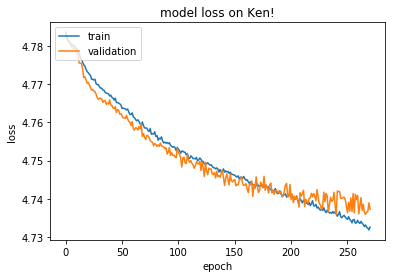

In [225]:
plot(history, title='Ken', metric='loss')

In [14]:
era_preds = np.argmax( model_dense.predict( data.x ), axis=1 )

In [15]:
from scipy import stats

stats.mode(era_preds)

ModeResult(mode=array([60], dtype=int64), count=array([172594]))

(array([1.25000e+02, 1.40000e+02, 7.48000e+02, 1.48100e+03, 2.24500e+03,
        2.04800e+03, 5.14000e+02, 3.10000e+01, 3.12900e+03, 1.24930e+04,
        3.30900e+03, 6.00000e+00, 2.90000e+01, 1.01690e+04, 6.91700e+03,
        4.01900e+03, 7.06000e+02, 1.70000e+01, 0.00000e+00, 2.76200e+04,
        1.04236e+05, 1.38040e+05, 8.75000e+02, 1.80296e+05, 1.19370e+04,
        3.12490e+04, 1.15270e+04, 1.57300e+03, 1.15800e+03, 8.03500e+03,
        1.53650e+04, 1.54660e+04, 4.09580e+04, 7.51680e+04, 1.03980e+04,
        1.52210e+04, 5.08900e+03, 2.27900e+03, 4.47000e+02, 1.72040e+04,
        1.82680e+04, 1.60750e+04, 9.44200e+03, 5.75200e+03, 2.13400e+03,
        9.17000e+02, 9.76500e+03, 7.33900e+03, 3.45500e+03, 1.29700e+03]),
 array([  5. ,   7.3,   9.6,  11.9,  14.2,  16.5,  18.8,  21.1,  23.4,
         25.7,  28. ,  30.3,  32.6,  34.9,  37.2,  39.5,  41.8,  44.1,
         46.4,  48.7,  51. ,  53.3,  55.6,  57.9,  60.2,  62.5,  64.8,
         67.1,  69.4,  71.7,  74. ,  76.3,  78.6,  80.9

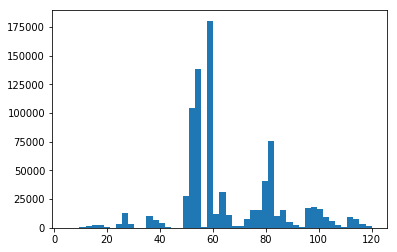

In [16]:
from matplotlib import pyplot

pyplot.hist(era_preds, bins=50)

In [17]:
len(era_data)

120

In [19]:
def GetEraModel(train_x, val_x, train_y, val_y ):

    model = Sequential([
        Dense(32, input_shape=(50,)),
        Activation('relu'),
        Dropout(0.3),
        Dense(100),
        Activation('relu'),
        Dense(100),
        Activation('relu'),
        Dropout(0.3),
        Dense(1),
        Activation('sigmoid'),
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['binary_crossentropy'])

    callbacks = [EarlyStopping(monitor='val_loss', 
              min_delta=0, 
              patience=20, 
              verbose=0, 
              mode='auto', 
              baseline=None, 
              restore_best_weights=True)]
    
    history = model.fit(train_x, 
                        train_y, 
                        validation_data=(val_x,val_y), 
                        epochs=100, 
                        callbacks=callbacks,
                        batch_size=1000, 
                        shuffle=True)
    
    return (model, history)



In [20]:
%%time
era_models = era_data | select( lambda era: GetEraModel( era[0], era[1], era[2], era[3] ) ) | as_list

Train on 2854 samples, validate on 1407 samples
Epoch 1/20
2854/2854 [==============================] - ETA: 0s - loss: 0.6979 - binary_crossentropy: 0.697 - 1s 186us/step - loss: 0.6969 - binary_crossentropy: 0.6969 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931
Epoch 2/20
2854/2854 [==============================] - ETA: 0s - loss: 0.6927 - binary_crossentropy: 0.692 - 0s 6us/step - loss: 0.6927 - binary_crossentropy: 0.6927 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932
Epoch 3/20
2854/2854 [==============================] - ETA: 0s - loss: 0.6930 - binary_crossentropy: 0.693 - 0s 6us/step - loss: 0.6946 - binary_crossentropy: 0.6946 - val_loss: 0.6930 - val_binary_crossentropy: 0.6930
Epoch 4/20
2854/2854 [==============================] - ETA: 0s - loss: 0.6913 - binary_crossentropy: 0.691 - 0s 5us/step - loss: 0.6924 - binary_crossentropy: 0.6924 - val_loss: 0.6929 - val_binary_crossentropy: 0.6929
Epoch 5/20
2854/2854 [==============================] - ETA: 0s - loss

Epoch 18/20
2872/2872 [==============================] - ETA: 0s - loss: 0.6842 - binary_crossentropy: 0.684 - 0s 6us/step - loss: 0.6871 - binary_crossentropy: 0.6871 - val_loss: 0.6845 - val_binary_crossentropy: 0.6845
Epoch 19/20
2872/2872 [==============================] - ETA: 0s - loss: 0.6882 - binary_crossentropy: 0.688 - 0s 6us/step - loss: 0.6864 - binary_crossentropy: 0.6864 - val_loss: 0.6840 - val_binary_crossentropy: 0.6840
Epoch 20/20
2872/2872 [==============================] - ETA: 0s - loss: 0.6840 - binary_crossentropy: 0.684 - 0s 6us/step - loss: 0.6860 - binary_crossentropy: 0.6860 - val_loss: 0.6836 - val_binary_crossentropy: 0.6836
Train on 2937 samples, validate on 1447 samples
Epoch 1/20
2937/2937 [==============================] - ETA: 1s - loss: 0.7222 - binary_crossentropy: 0.722 - 1s 205us/step - loss: 0.7078 - binary_crossentropy: 0.7078 - val_loss: 0.6933 - val_binary_crossentropy: 0.6933
Epoch 2/20
2937/2937 [==============================] - ETA: 0s - l

Epoch 15/20
2702/2702 [==============================] - ETA: 0s - loss: 0.6844 - binary_crossentropy: 0.684 - 0s 6us/step - loss: 0.6875 - binary_crossentropy: 0.6875 - val_loss: 0.6828 - val_binary_crossentropy: 0.6828
Epoch 16/20
2702/2702 [==============================] - ETA: 0s - loss: 0.6881 - binary_crossentropy: 0.688 - 0s 6us/step - loss: 0.6868 - binary_crossentropy: 0.6868 - val_loss: 0.6823 - val_binary_crossentropy: 0.6823
Epoch 17/20
2702/2702 [==============================] - ETA: 0s - loss: 0.6845 - binary_crossentropy: 0.684 - 0s 6us/step - loss: 0.6852 - binary_crossentropy: 0.6852 - val_loss: 0.6818 - val_binary_crossentropy: 0.6818
Epoch 18/20
2702/2702 [==============================] - ETA: 0s - loss: 0.6839 - binary_crossentropy: 0.683 - 0s 6us/step - loss: 0.6856 - binary_crossentropy: 0.6856 - val_loss: 0.6818 - val_binary_crossentropy: 0.6818
Epoch 19/20
2702/2702 [==============================] - ETA: 0s - loss: 0.6893 - binary_crossentropy: 0.689 - 0s 6u

Epoch 12/20
2731/2731 [==============================] - ETA: 0s - loss: 0.6896 - binary_crossentropy: 0.689 - 0s 5us/step - loss: 0.6893 - binary_crossentropy: 0.6893 - val_loss: 0.6909 - val_binary_crossentropy: 0.6909
Epoch 13/20
2731/2731 [==============================] - ETA: 0s - loss: 0.6902 - binary_crossentropy: 0.690 - 0s 5us/step - loss: 0.6890 - binary_crossentropy: 0.6890 - val_loss: 0.6906 - val_binary_crossentropy: 0.6906
Epoch 14/20
2731/2731 [==============================] - ETA: 0s - loss: 0.6942 - binary_crossentropy: 0.694 - 0s 5us/step - loss: 0.6900 - binary_crossentropy: 0.6900 - val_loss: 0.6913 - val_binary_crossentropy: 0.6913
Epoch 15/20
2731/2731 [==============================] - ETA: 0s - loss: 0.6898 - binary_crossentropy: 0.689 - 0s 5us/step - loss: 0.6901 - binary_crossentropy: 0.6901 - val_loss: 0.6907 - val_binary_crossentropy: 0.6907
Epoch 16/20
2731/2731 [==============================] - ETA: 0s - loss: 0.6837 - binary_crossentropy: 0.683 - 0s 5u

Epoch 9/20
2974/2974 [==============================] - ETA: 0s - loss: 0.6936 - binary_crossentropy: 0.693 - 0s 5us/step - loss: 0.6912 - binary_crossentropy: 0.6912 - val_loss: 0.6913 - val_binary_crossentropy: 0.6913
Epoch 10/20
2974/2974 [==============================] - ETA: 0s - loss: 0.6911 - binary_crossentropy: 0.691 - 0s 5us/step - loss: 0.6907 - binary_crossentropy: 0.6907 - val_loss: 0.6910 - val_binary_crossentropy: 0.6910
Epoch 11/20
2974/2974 [==============================] - ETA: 0s - loss: 0.6925 - binary_crossentropy: 0.692 - 0s 5us/step - loss: 0.6909 - binary_crossentropy: 0.6909 - val_loss: 0.6910 - val_binary_crossentropy: 0.6910
Epoch 12/20
2974/2974 [==============================] - ETA: 0s - loss: 0.6885 - binary_crossentropy: 0.688 - 0s 5us/step - loss: 0.6896 - binary_crossentropy: 0.6896 - val_loss: 0.6909 - val_binary_crossentropy: 0.6909
Epoch 13/20
2974/2974 [==============================] - ETA: 0s - loss: 0.6898 - binary_crossentropy: 0.689 - 0s 6us

Epoch 6/20
3276/3276 [==============================] - ETA: 0s - loss: 0.6885 - binary_crossentropy: 0.688 - 0s 6us/step - loss: 0.6926 - binary_crossentropy: 0.6926 - val_loss: 0.6891 - val_binary_crossentropy: 0.6891
Epoch 7/20
3276/3276 [==============================] - ETA: 0s - loss: 0.6940 - binary_crossentropy: 0.694 - 0s 6us/step - loss: 0.6927 - binary_crossentropy: 0.6927 - val_loss: 0.6887 - val_binary_crossentropy: 0.6887
Epoch 8/20
3276/3276 [==============================] - ETA: 0s - loss: 0.6933 - binary_crossentropy: 0.693 - 0s 5us/step - loss: 0.6923 - binary_crossentropy: 0.6923 - val_loss: 0.6884 - val_binary_crossentropy: 0.6884
Epoch 9/20
3276/3276 [==============================] - ETA: 0s - loss: 0.6946 - binary_crossentropy: 0.694 - 0s 5us/step - loss: 0.6937 - binary_crossentropy: 0.6937 - val_loss: 0.6882 - val_binary_crossentropy: 0.6882
Epoch 10/20
3276/3276 [==============================] - ETA: 0s - loss: 0.6927 - binary_crossentropy: 0.692 - 0s 6us/st

Epoch 3/20
2986/2986 [==============================] - ETA: 0s - loss: 0.6973 - binary_crossentropy: 0.697 - 0s 5us/step - loss: 0.6962 - binary_crossentropy: 0.6962 - val_loss: 0.6892 - val_binary_crossentropy: 0.6892
Epoch 4/20
2986/2986 [==============================] - ETA: 0s - loss: 0.6953 - binary_crossentropy: 0.695 - 0s 5us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - val_loss: 0.6887 - val_binary_crossentropy: 0.6887
Epoch 5/20
2986/2986 [==============================] - ETA: 0s - loss: 0.6936 - binary_crossentropy: 0.693 - 0s 5us/step - loss: 0.6946 - binary_crossentropy: 0.6946 - val_loss: 0.6891 - val_binary_crossentropy: 0.6891
Epoch 6/20
2986/2986 [==============================] - ETA: 0s - loss: 0.6927 - binary_crossentropy: 0.692 - 0s 5us/step - loss: 0.6896 - binary_crossentropy: 0.6896 - val_loss: 0.6886 - val_binary_crossentropy: 0.6886
Epoch 7/20
2986/2986 [==============================] - ETA: 0s - loss: 0.6921 - binary_crossentropy: 0.692 - 0s 6us/ste

Epoch 20/20
3005/3005 [==============================] - ETA: 0s - loss: 0.6907 - binary_crossentropy: 0.690 - 0s 6us/step - loss: 0.6933 - binary_crossentropy: 0.6933 - val_loss: 0.6955 - val_binary_crossentropy: 0.6955
Train on 2600 samples, validate on 1282 samples
Epoch 1/20
2600/2600 [==============================] - ETA: 1s - loss: 0.6964 - binary_crossentropy: 0.696 - 1s 472us/step - loss: 0.6973 - binary_crossentropy: 0.6973 - val_loss: 0.6916 - val_binary_crossentropy: 0.6916
Epoch 2/20
2600/2600 [==============================] - ETA: 0s - loss: 0.6955 - binary_crossentropy: 0.695 - 0s 6us/step - loss: 0.6959 - binary_crossentropy: 0.6959 - val_loss: 0.6919 - val_binary_crossentropy: 0.6919
Epoch 3/20
2600/2600 [==============================] - ETA: 0s - loss: 0.6987 - binary_crossentropy: 0.698 - 0s 6us/step - loss: 0.6959 - binary_crossentropy: 0.6959 - val_loss: 0.6926 - val_binary_crossentropy: 0.6926
Epoch 4/20
2600/2600 [==============================] - ETA: 0s - los

Epoch 17/20
3094/3094 [==============================] - ETA: 0s - loss: 0.6836 - binary_crossentropy: 0.683 - 0s 6us/step - loss: 0.6850 - binary_crossentropy: 0.6850 - val_loss: 0.6765 - val_binary_crossentropy: 0.6765
Epoch 18/20
3094/3094 [==============================] - ETA: 0s - loss: 0.6849 - binary_crossentropy: 0.684 - 0s 6us/step - loss: 0.6837 - binary_crossentropy: 0.6837 - val_loss: 0.6754 - val_binary_crossentropy: 0.6754
Epoch 19/20
3094/3094 [==============================] - ETA: 0s - loss: 0.6816 - binary_crossentropy: 0.681 - 0s 6us/step - loss: 0.6807 - binary_crossentropy: 0.6807 - val_loss: 0.6791 - val_binary_crossentropy: 0.6791
Epoch 20/20
3094/3094 [==============================] - ETA: 0s - loss: 0.6874 - binary_crossentropy: 0.687 - 0s 6us/step - loss: 0.6871 - binary_crossentropy: 0.6871 - val_loss: 0.6753 - val_binary_crossentropy: 0.6753
Train on 3135 samples, validate on 1545 samples
Epoch 1/20
3135/3135 [==============================] - ETA: 2s - lo

Epoch 14/20
2543/2543 [==============================] - ETA: 0s - loss: 0.6742 - binary_crossentropy: 0.674 - 0s 6us/step - loss: 0.6744 - binary_crossentropy: 0.6744 - val_loss: 0.6710 - val_binary_crossentropy: 0.6710
Epoch 15/20
2543/2543 [==============================] - ETA: 0s - loss: 0.6681 - binary_crossentropy: 0.668 - 0s 7us/step - loss: 0.6692 - binary_crossentropy: 0.6692 - val_loss: 0.6688 - val_binary_crossentropy: 0.6688
Epoch 16/20
2543/2543 [==============================] - ETA: 0s - loss: 0.6794 - binary_crossentropy: 0.679 - 0s 7us/step - loss: 0.6741 - binary_crossentropy: 0.6741 - val_loss: 0.6672 - val_binary_crossentropy: 0.6672
Epoch 17/20
2543/2543 [==============================] - ETA: 0s - loss: 0.6707 - binary_crossentropy: 0.670 - 0s 7us/step - loss: 0.6663 - binary_crossentropy: 0.6663 - val_loss: 0.6656 - val_binary_crossentropy: 0.6656
Epoch 18/20
2543/2543 [==============================] - ETA: 0s - loss: 0.6681 - binary_crossentropy: 0.668 - 0s 6u

Epoch 11/20
2994/2994 [==============================] - ETA: 0s - loss: 0.6835 - binary_crossentropy: 0.683 - 0s 5us/step - loss: 0.6856 - binary_crossentropy: 0.6856 - val_loss: 0.6819 - val_binary_crossentropy: 0.6819
Epoch 12/20
2994/2994 [==============================] - ETA: 0s - loss: 0.6819 - binary_crossentropy: 0.681 - 0s 5us/step - loss: 0.6843 - binary_crossentropy: 0.6843 - val_loss: 0.6808 - val_binary_crossentropy: 0.6808
Epoch 13/20
2994/2994 [==============================] - ETA: 0s - loss: 0.6885 - binary_crossentropy: 0.688 - 0s 5us/step - loss: 0.6849 - binary_crossentropy: 0.6849 - val_loss: 0.6802 - val_binary_crossentropy: 0.6802
Epoch 14/20
2994/2994 [==============================] - ETA: 0s - loss: 0.6809 - binary_crossentropy: 0.680 - 0s 5us/step - loss: 0.6807 - binary_crossentropy: 0.6807 - val_loss: 0.6804 - val_binary_crossentropy: 0.6804
Epoch 15/20
2994/2994 [==============================] - ETA: 0s - loss: 0.6792 - binary_crossentropy: 0.679 - 0s 5u

Epoch 8/20
2993/2993 [==============================] - ETA: 0s - loss: 0.6933 - binary_crossentropy: 0.693 - 0s 6us/step - loss: 0.6923 - binary_crossentropy: 0.6923 - val_loss: 0.6915 - val_binary_crossentropy: 0.6915
Epoch 9/20
2993/2993 [==============================] - ETA: 0s - loss: 0.6909 - binary_crossentropy: 0.690 - 0s 6us/step - loss: 0.6907 - binary_crossentropy: 0.6907 - val_loss: 0.6912 - val_binary_crossentropy: 0.6912
Epoch 10/20
2993/2993 [==============================] - ETA: 0s - loss: 0.6921 - binary_crossentropy: 0.692 - 0s 5us/step - loss: 0.6920 - binary_crossentropy: 0.6920 - val_loss: 0.6908 - val_binary_crossentropy: 0.6908
Epoch 11/20
2993/2993 [==============================] - ETA: 0s - loss: 0.6896 - binary_crossentropy: 0.689 - 0s 5us/step - loss: 0.6904 - binary_crossentropy: 0.6904 - val_loss: 0.6903 - val_binary_crossentropy: 0.6903
Epoch 12/20
2993/2993 [==============================] - ETA: 0s - loss: 0.6917 - binary_crossentropy: 0.691 - 0s 7us/

Epoch 5/20
2588/2588 [==============================] - ETA: 0s - loss: 0.6933 - binary_crossentropy: 0.693 - 0s 7us/step - loss: 0.6920 - binary_crossentropy: 0.6920 - val_loss: 0.6900 - val_binary_crossentropy: 0.6900
Epoch 6/20
2588/2588 [==============================] - ETA: 0s - loss: 0.6905 - binary_crossentropy: 0.690 - 0s 7us/step - loss: 0.6905 - binary_crossentropy: 0.6905 - val_loss: 0.6903 - val_binary_crossentropy: 0.6903
Epoch 7/20
2588/2588 [==============================] - ETA: 0s - loss: 0.6891 - binary_crossentropy: 0.689 - 0s 7us/step - loss: 0.6886 - binary_crossentropy: 0.6886 - val_loss: 0.6910 - val_binary_crossentropy: 0.6910
Epoch 8/20
2588/2588 [==============================] - ETA: 0s - loss: 0.6887 - binary_crossentropy: 0.688 - 0s 7us/step - loss: 0.6883 - binary_crossentropy: 0.6883 - val_loss: 0.6914 - val_binary_crossentropy: 0.6914
Epoch 9/20
2588/2588 [==============================] - ETA: 0s - loss: 0.6846 - binary_crossentropy: 0.684 - 0s 7us/ste

Epoch 2/20
2954/2954 [==============================] - ETA: 0s - loss: 0.6981 - binary_crossentropy: 0.698 - 0s 6us/step - loss: 0.7009 - binary_crossentropy: 0.7009 - val_loss: 0.6957 - val_binary_crossentropy: 0.6957
Epoch 3/20
2954/2954 [==============================] - ETA: 0s - loss: 0.6963 - binary_crossentropy: 0.696 - 0s 6us/step - loss: 0.6947 - binary_crossentropy: 0.6947 - val_loss: 0.6917 - val_binary_crossentropy: 0.6917
Epoch 4/20
2954/2954 [==============================] - ETA: 0s - loss: 0.6944 - binary_crossentropy: 0.694 - 0s 6us/step - loss: 0.6936 - binary_crossentropy: 0.6936 - val_loss: 0.6909 - val_binary_crossentropy: 0.6909
Epoch 5/20
2954/2954 [==============================] - ETA: 0s - loss: 0.6949 - binary_crossentropy: 0.694 - 0s 6us/step - loss: 0.6938 - binary_crossentropy: 0.6938 - val_loss: 0.6906 - val_binary_crossentropy: 0.6906
Epoch 6/20
2954/2954 [==============================] - ETA: 0s - loss: 0.6934 - binary_crossentropy: 0.693 - 0s 6us/ste

Epoch 19/20
3236/3236 [==============================] - ETA: 0s - loss: 0.6929 - binary_crossentropy: 0.692 - 0s 7us/step - loss: 0.6914 - binary_crossentropy: 0.6914 - val_loss: 0.6920 - val_binary_crossentropy: 0.6920
Epoch 20/20
3236/3236 [==============================] - ETA: 0s - loss: 0.6907 - binary_crossentropy: 0.690 - 0s 7us/step - loss: 0.6895 - binary_crossentropy: 0.6895 - val_loss: 0.6919 - val_binary_crossentropy: 0.6919
Train on 3134 samples, validate on 1545 samples
Epoch 1/20
3134/3134 [==============================] - ETA: 3s - loss: 0.6986 - binary_crossentropy: 0.698 - 2s 627us/step - loss: 0.6970 - binary_crossentropy: 0.6970 - val_loss: 0.6928 - val_binary_crossentropy: 0.6928
Epoch 2/20
3134/3134 [==============================] - ETA: 0s - loss: 0.6976 - binary_crossentropy: 0.697 - 0s 7us/step - loss: 0.6952 - binary_crossentropy: 0.6952 - val_loss: 0.6943 - val_binary_crossentropy: 0.6943
Epoch 3/20
3134/3134 [==============================] - ETA: 0s - lo

Epoch 16/20
3030/3030 [==============================] - ETA: 0s - loss: 0.6926 - binary_crossentropy: 0.692 - 0s 7us/step - loss: 0.6928 - binary_crossentropy: 0.6928 - val_loss: 0.6889 - val_binary_crossentropy: 0.6889
Epoch 17/20
3030/3030 [==============================] - ETA: 0s - loss: 0.6915 - binary_crossentropy: 0.691 - 0s 7us/step - loss: 0.6931 - binary_crossentropy: 0.6931 - val_loss: 0.6890 - val_binary_crossentropy: 0.6890
Epoch 18/20
3030/3030 [==============================] - ETA: 0s - loss: 0.6910 - binary_crossentropy: 0.691 - 0s 7us/step - loss: 0.6903 - binary_crossentropy: 0.6903 - val_loss: 0.6893 - val_binary_crossentropy: 0.6893
Epoch 19/20
3030/3030 [==============================] - ETA: 0s - loss: 0.6902 - binary_crossentropy: 0.690 - 0s 7us/step - loss: 0.6905 - binary_crossentropy: 0.6905 - val_loss: 0.6894 - val_binary_crossentropy: 0.6894
Epoch 20/20
3030/3030 [==============================] - ETA: 0s - loss: 0.6892 - binary_crossentropy: 0.689 - 0s 7u

Epoch 13/20
2866/2866 [==============================] - ETA: 0s - loss: 0.6902 - binary_crossentropy: 0.690 - 0s 7us/step - loss: 0.6891 - binary_crossentropy: 0.6891 - val_loss: 0.6863 - val_binary_crossentropy: 0.6863
Epoch 14/20
2866/2866 [==============================] - ETA: 0s - loss: 0.6889 - binary_crossentropy: 0.688 - 0s 6us/step - loss: 0.6901 - binary_crossentropy: 0.6901 - val_loss: 0.6859 - val_binary_crossentropy: 0.6859
Epoch 15/20
2866/2866 [==============================] - ETA: 0s - loss: 0.6881 - binary_crossentropy: 0.688 - 0s 6us/step - loss: 0.6885 - binary_crossentropy: 0.6885 - val_loss: 0.6861 - val_binary_crossentropy: 0.6861
Epoch 16/20
2866/2866 [==============================] - ETA: 0s - loss: 0.6853 - binary_crossentropy: 0.685 - 0s 6us/step - loss: 0.6864 - binary_crossentropy: 0.6864 - val_loss: 0.6853 - val_binary_crossentropy: 0.6853
Epoch 17/20
2866/2866 [==============================] - ETA: 0s - loss: 0.6849 - binary_crossentropy: 0.684 - 0s 6u

Epoch 10/20
3286/3286 [==============================] - ETA: 0s - loss: 0.6879 - binary_crossentropy: 0.687 - 0s 7us/step - loss: 0.6910 - binary_crossentropy: 0.6910 - val_loss: 0.6897 - val_binary_crossentropy: 0.6897
Epoch 11/20
3286/3286 [==============================] - ETA: 0s - loss: 0.6933 - binary_crossentropy: 0.693 - 0s 7us/step - loss: 0.6902 - binary_crossentropy: 0.6902 - val_loss: 0.6889 - val_binary_crossentropy: 0.6889
Epoch 12/20
3286/3286 [==============================] - ETA: 0s - loss: 0.6920 - binary_crossentropy: 0.692 - 0s 7us/step - loss: 0.6926 - binary_crossentropy: 0.6926 - val_loss: 0.6889 - val_binary_crossentropy: 0.6889
Epoch 13/20
3286/3286 [==============================] - ETA: 0s - loss: 0.6894 - binary_crossentropy: 0.689 - 0s 6us/step - loss: 0.6912 - binary_crossentropy: 0.6912 - val_loss: 0.6885 - val_binary_crossentropy: 0.6885
Epoch 14/20
3286/3286 [==============================] - ETA: 0s - loss: 0.6894 - binary_crossentropy: 0.689 - 0s 6u

Epoch 7/20
3128/3128 [==============================] - ETA: 0s - loss: 0.6970 - binary_crossentropy: 0.697 - 0s 7us/step - loss: 0.6943 - binary_crossentropy: 0.6943 - val_loss: 0.6944 - val_binary_crossentropy: 0.6944
Epoch 8/20
3128/3128 [==============================] - ETA: 0s - loss: 0.6910 - binary_crossentropy: 0.691 - 0s 7us/step - loss: 0.6927 - binary_crossentropy: 0.6927 - val_loss: 0.6942 - val_binary_crossentropy: 0.6942
Epoch 9/20
3128/3128 [==============================] - ETA: 0s - loss: 0.6956 - binary_crossentropy: 0.695 - 0s 7us/step - loss: 0.6949 - binary_crossentropy: 0.6949 - val_loss: 0.6942 - val_binary_crossentropy: 0.6942
Epoch 10/20
3128/3128 [==============================] - ETA: 0s - loss: 0.6930 - binary_crossentropy: 0.693 - 0s 8us/step - loss: 0.6924 - binary_crossentropy: 0.6924 - val_loss: 0.6937 - val_binary_crossentropy: 0.6937
Epoch 11/20
3128/3128 [==============================] - ETA: 0s - loss: 0.6914 - binary_crossentropy: 0.691 - 0s 7us/s

Epoch 4/20
2720/2720 [==============================] - ETA: 0s - loss: 0.6960 - binary_crossentropy: 0.696 - 0s 7us/step - loss: 0.6935 - binary_crossentropy: 0.6935 - val_loss: 0.6937 - val_binary_crossentropy: 0.6937
Epoch 5/20
2720/2720 [==============================] - ETA: 0s - loss: 0.6968 - binary_crossentropy: 0.696 - 0s 7us/step - loss: 0.6936 - binary_crossentropy: 0.6936 - val_loss: 0.6933 - val_binary_crossentropy: 0.6933
Epoch 6/20
2720/2720 [==============================] - ETA: 0s - loss: 0.6927 - binary_crossentropy: 0.692 - 0s 7us/step - loss: 0.6931 - binary_crossentropy: 0.6931 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932
Epoch 7/20
2720/2720 [==============================] - ETA: 0s - loss: 0.6927 - binary_crossentropy: 0.692 - 0s 8us/step - loss: 0.6917 - binary_crossentropy: 0.6917 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931
Epoch 8/20
2720/2720 [==============================] - ETA: 0s - loss: 0.6925 - binary_crossentropy: 0.692 - 0s 7us/ste

Train on 2283 samples, validate on 1125 samples
Epoch 1/20
2283/2283 [==============================] - ETA: 3s - loss: 0.6949 - binary_crossentropy: 0.694 - 3s 1ms/step - loss: 0.6944 - binary_crossentropy: 0.6944 - val_loss: 0.6937 - val_binary_crossentropy: 0.6937
Epoch 2/20
2283/2283 [==============================] - ETA: 0s - loss: 0.6959 - binary_crossentropy: 0.695 - 0s 9us/step - loss: 0.6953 - binary_crossentropy: 0.6953 - val_loss: 0.6914 - val_binary_crossentropy: 0.6914
Epoch 3/20
2283/2283 [==============================] - ETA: 0s - loss: 0.6951 - binary_crossentropy: 0.695 - 0s 8us/step - loss: 0.6942 - binary_crossentropy: 0.6942 - val_loss: 0.6898 - val_binary_crossentropy: 0.6898
Epoch 4/20
2283/2283 [==============================] - ETA: 0s - loss: 0.6953 - binary_crossentropy: 0.695 - 0s 9us/step - loss: 0.6938 - binary_crossentropy: 0.6938 - val_loss: 0.6890 - val_binary_crossentropy: 0.6890
Epoch 5/20
2283/2283 [==============================] - ETA: 0s - loss: 

Epoch 18/20
3042/3042 [==============================] - ETA: 0s - loss: 0.6873 - binary_crossentropy: 0.687 - 0s 8us/step - loss: 0.6833 - binary_crossentropy: 0.6833 - val_loss: 0.6772 - val_binary_crossentropy: 0.6772
Epoch 19/20
3042/3042 [==============================] - ETA: 0s - loss: 0.6885 - binary_crossentropy: 0.688 - 0s 7us/step - loss: 0.6855 - binary_crossentropy: 0.6855 - val_loss: 0.6771 - val_binary_crossentropy: 0.6771
Epoch 20/20
3042/3042 [==============================] - ETA: 0s - loss: 0.6789 - binary_crossentropy: 0.678 - 0s 7us/step - loss: 0.6833 - binary_crossentropy: 0.6833 - val_loss: 0.6783 - val_binary_crossentropy: 0.6783
Train on 3209 samples, validate on 1582 samples
Epoch 1/20
3209/3209 [==============================] - ETA: 5s - loss: 0.6964 - binary_crossentropy: 0.696 - 3s 877us/step - loss: 0.6930 - binary_crossentropy: 0.6930 - val_loss: 0.6925 - val_binary_crossentropy: 0.6925
Epoch 2/20
3209/3209 [==============================] - ETA: 0s - l

Epoch 15/20
2132/2132 [==============================] - ETA: 0s - loss: 0.6925 - binary_crossentropy: 0.692 - 0s 8us/step - loss: 0.6898 - binary_crossentropy: 0.6898 - val_loss: 0.6874 - val_binary_crossentropy: 0.6874
Epoch 16/20
2132/2132 [==============================] - ETA: 0s - loss: 0.6917 - binary_crossentropy: 0.691 - 0s 8us/step - loss: 0.6882 - binary_crossentropy: 0.6882 - val_loss: 0.6868 - val_binary_crossentropy: 0.6868
Epoch 17/20
2132/2132 [==============================] - ETA: 0s - loss: 0.6911 - binary_crossentropy: 0.691 - 0s 9us/step - loss: 0.6899 - binary_crossentropy: 0.6899 - val_loss: 0.6864 - val_binary_crossentropy: 0.6864
Epoch 18/20
2132/2132 [==============================] - ETA: 0s - loss: 0.6867 - binary_crossentropy: 0.686 - 0s 8us/step - loss: 0.6896 - binary_crossentropy: 0.6896 - val_loss: 0.6856 - val_binary_crossentropy: 0.6856
Epoch 19/20
2132/2132 [==============================] - ETA: 0s - loss: 0.6858 - binary_crossentropy: 0.685 - 0s 8u

Epoch 12/20
2979/2979 [==============================] - ETA: 0s - loss: 0.6900 - binary_crossentropy: 0.690 - 0s 6us/step - loss: 0.6922 - binary_crossentropy: 0.6922 - val_loss: 0.6926 - val_binary_crossentropy: 0.6926
Epoch 13/20
2979/2979 [==============================] - ETA: 0s - loss: 0.6946 - binary_crossentropy: 0.694 - 0s 6us/step - loss: 0.6930 - binary_crossentropy: 0.6930 - val_loss: 0.6924 - val_binary_crossentropy: 0.6924
Epoch 14/20
2979/2979 [==============================] - ETA: 0s - loss: 0.6925 - binary_crossentropy: 0.692 - 0s 7us/step - loss: 0.6911 - binary_crossentropy: 0.6911 - val_loss: 0.6924 - val_binary_crossentropy: 0.6924
Epoch 15/20
2979/2979 [==============================] - ETA: 0s - loss: 0.6917 - binary_crossentropy: 0.691 - 0s 7us/step - loss: 0.6927 - binary_crossentropy: 0.6927 - val_loss: 0.6923 - val_binary_crossentropy: 0.6923
Epoch 16/20
2979/2979 [==============================] - ETA: 0s - loss: 0.6929 - binary_crossentropy: 0.692 - 0s 7u

Epoch 9/20
2968/2968 [==============================] - ETA: 0s - loss: 0.6915 - binary_crossentropy: 0.691 - 0s 6us/step - loss: 0.6925 - binary_crossentropy: 0.6925 - val_loss: 0.6921 - val_binary_crossentropy: 0.6921
Epoch 10/20
2968/2968 [==============================] - ETA: 0s - loss: 0.6926 - binary_crossentropy: 0.692 - 0s 6us/step - loss: 0.6933 - binary_crossentropy: 0.6933 - val_loss: 0.6918 - val_binary_crossentropy: 0.6918
Epoch 11/20
2968/2968 [==============================] - ETA: 0s - loss: 0.6942 - binary_crossentropy: 0.694 - 0s 7us/step - loss: 0.6931 - binary_crossentropy: 0.6931 - val_loss: 0.6916 - val_binary_crossentropy: 0.6916
Epoch 12/20
2968/2968 [==============================] - ETA: 0s - loss: 0.6919 - binary_crossentropy: 0.691 - 0s 6us/step - loss: 0.6911 - binary_crossentropy: 0.6911 - val_loss: 0.6914 - val_binary_crossentropy: 0.6914
Epoch 13/20
2968/2968 [==============================] - ETA: 0s - loss: 0.6905 - binary_crossentropy: 0.690 - 0s 6us

Epoch 6/20
3287/3287 [==============================] - ETA: 0s - loss: 0.6931 - binary_crossentropy: 0.693 - 0s 7us/step - loss: 0.6967 - binary_crossentropy: 0.6967 - val_loss: 0.6933 - val_binary_crossentropy: 0.6933
Epoch 7/20
3287/3287 [==============================] - ETA: 0s - loss: 0.6983 - binary_crossentropy: 0.698 - 0s 8us/step - loss: 0.6957 - binary_crossentropy: 0.6957 - val_loss: 0.6926 - val_binary_crossentropy: 0.6926
Epoch 8/20
3287/3287 [==============================] - ETA: 0s - loss: 0.7013 - binary_crossentropy: 0.701 - 0s 7us/step - loss: 0.6962 - binary_crossentropy: 0.6962 - val_loss: 0.6927 - val_binary_crossentropy: 0.6927
Epoch 9/20
3287/3287 [==============================] - ETA: 0s - loss: 0.6933 - binary_crossentropy: 0.693 - 0s 7us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - val_loss: 0.6927 - val_binary_crossentropy: 0.6927
Epoch 10/20
3287/3287 [==============================] - ETA: 0s - loss: 0.6914 - binary_crossentropy: 0.691 - 0s 7us/st

Epoch 3/20
2832/2832 [==============================] - ETA: 0s - loss: 0.6954 - binary_crossentropy: 0.695 - 0s 7us/step - loss: 0.6952 - binary_crossentropy: 0.6952 - val_loss: 0.6946 - val_binary_crossentropy: 0.6946
Epoch 4/20
2832/2832 [==============================] - ETA: 0s - loss: 0.6946 - binary_crossentropy: 0.694 - 0s 8us/step - loss: 0.6958 - binary_crossentropy: 0.6958 - val_loss: 0.6929 - val_binary_crossentropy: 0.6929
Epoch 5/20
2832/2832 [==============================] - ETA: 0s - loss: 0.6946 - binary_crossentropy: 0.694 - 0s 7us/step - loss: 0.6938 - binary_crossentropy: 0.6938 - val_loss: 0.6910 - val_binary_crossentropy: 0.6910
Epoch 6/20
2832/2832 [==============================] - ETA: 0s - loss: 0.6911 - binary_crossentropy: 0.691 - 0s 7us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - val_loss: 0.6910 - val_binary_crossentropy: 0.6910
Epoch 7/20
2832/2832 [==============================] - ETA: 0s - loss: 0.6919 - binary_crossentropy: 0.691 - 0s 6us/ste

Epoch 20/20
2830/2830 [==============================] - ETA: 0s - loss: 0.6884 - binary_crossentropy: 0.688 - 0s 7us/step - loss: 0.6887 - binary_crossentropy: 0.6887 - val_loss: 0.6909 - val_binary_crossentropy: 0.6909
Train on 3148 samples, validate on 1551 samples
Epoch 1/20
3148/3148 [==============================] - ETA: 6s - loss: 0.6982 - binary_crossentropy: 0.698 - 4s 1ms/step - loss: 0.6952 - binary_crossentropy: 0.6952 - val_loss: 0.6937 - val_binary_crossentropy: 0.6937
Epoch 2/20
3148/3148 [==============================] - ETA: 0s - loss: 0.6969 - binary_crossentropy: 0.696 - 0s 9us/step - loss: 0.6952 - binary_crossentropy: 0.6952 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931
Epoch 3/20
3148/3148 [==============================] - ETA: 0s - loss: 0.6948 - binary_crossentropy: 0.694 - 0s 9us/step - loss: 0.6933 - binary_crossentropy: 0.6933 - val_loss: 0.6929 - val_binary_crossentropy: 0.6929
Epoch 4/20
3148/3148 [==============================] - ETA: 0s - loss:

Epoch 17/20
2651/2651 [==============================] - ETA: 0s - loss: 0.6922 - binary_crossentropy: 0.692 - 0s 7us/step - loss: 0.6928 - binary_crossentropy: 0.6928 - val_loss: 0.6910 - val_binary_crossentropy: 0.6910
Epoch 18/20
2651/2651 [==============================] - ETA: 0s - loss: 0.6891 - binary_crossentropy: 0.689 - 0s 7us/step - loss: 0.6917 - binary_crossentropy: 0.6917 - val_loss: 0.6908 - val_binary_crossentropy: 0.6908
Epoch 19/20
2651/2651 [==============================] - ETA: 0s - loss: 0.6891 - binary_crossentropy: 0.689 - 0s 7us/step - loss: 0.6903 - binary_crossentropy: 0.6903 - val_loss: 0.6903 - val_binary_crossentropy: 0.6903
Epoch 20/20
2651/2651 [==============================] - ETA: 0s - loss: 0.6917 - binary_crossentropy: 0.691 - 0s 7us/step - loss: 0.6907 - binary_crossentropy: 0.6907 - val_loss: 0.6901 - val_binary_crossentropy: 0.6901
Train on 2568 samples, validate on 1265 samples
Epoch 1/20
2568/2568 [==============================] - ETA: 5s - lo

Epoch 14/20
3177/3177 [==============================] - ETA: 0s - loss: 0.6947 - binary_crossentropy: 0.694 - 0s 8us/step - loss: 0.6931 - binary_crossentropy: 0.6931 - val_loss: 0.6941 - val_binary_crossentropy: 0.6941
Epoch 15/20
3177/3177 [==============================] - ETA: 0s - loss: 0.6924 - binary_crossentropy: 0.692 - 0s 8us/step - loss: 0.6919 - binary_crossentropy: 0.6919 - val_loss: 0.6940 - val_binary_crossentropy: 0.6940
Epoch 16/20
3177/3177 [==============================] - ETA: 0s - loss: 0.6927 - binary_crossentropy: 0.692 - 0s 8us/step - loss: 0.6924 - binary_crossentropy: 0.6924 - val_loss: 0.6939 - val_binary_crossentropy: 0.6939
Epoch 17/20
3177/3177 [==============================] - ETA: 0s - loss: 0.6945 - binary_crossentropy: 0.694 - 0s 9us/step - loss: 0.6939 - binary_crossentropy: 0.6939 - val_loss: 0.6939 - val_binary_crossentropy: 0.6939
Epoch 18/20
3177/3177 [==============================] - ETA: 0s - loss: 0.6927 - binary_crossentropy: 0.692 - 0s 8u

Epoch 11/20
1601/1601 [==============================] - ETA: 0s - loss: 0.6904 - binary_crossentropy: 0.690 - 0s 9us/step - loss: 0.6915 - binary_crossentropy: 0.6915 - val_loss: 0.6908 - val_binary_crossentropy: 0.6908
Epoch 12/20
1601/1601 [==============================] - ETA: 0s - loss: 0.6909 - binary_crossentropy: 0.690 - 0s 8us/step - loss: 0.6916 - binary_crossentropy: 0.6916 - val_loss: 0.6907 - val_binary_crossentropy: 0.6907
Epoch 13/20
1601/1601 [==============================] - ETA: 0s - loss: 0.6936 - binary_crossentropy: 0.693 - 0s 9us/step - loss: 0.6929 - binary_crossentropy: 0.6929 - val_loss: 0.6906 - val_binary_crossentropy: 0.6906
Epoch 14/20
1601/1601 [==============================] - ETA: 0s - loss: 0.6909 - binary_crossentropy: 0.690 - 0s 11us/step - loss: 0.6908 - binary_crossentropy: 0.6908 - val_loss: 0.6906 - val_binary_crossentropy: 0.6906
Epoch 15/20
1601/1601 [==============================] - ETA: 0s - loss: 0.6920 - binary_crossentropy: 0.692 - 0s 8

Epoch 8/20
1717/1717 [==============================] - ETA: 0s - loss: 0.6876 - binary_crossentropy: 0.687 - 0s 10us/step - loss: 0.6885 - binary_crossentropy: 0.6885 - val_loss: 0.6866 - val_binary_crossentropy: 0.6866
Epoch 9/20
1717/1717 [==============================] - ETA: 0s - loss: 0.6868 - binary_crossentropy: 0.686 - 0s 9us/step - loss: 0.6870 - binary_crossentropy: 0.6870 - val_loss: 0.6852 - val_binary_crossentropy: 0.6852
Epoch 10/20
1717/1717 [==============================] - ETA: 0s - loss: 0.6870 - binary_crossentropy: 0.687 - 0s 9us/step - loss: 0.6885 - binary_crossentropy: 0.6885 - val_loss: 0.6842 - val_binary_crossentropy: 0.6842
Epoch 11/20
1717/1717 [==============================] - ETA: 0s - loss: 0.6867 - binary_crossentropy: 0.686 - 0s 8us/step - loss: 0.6842 - binary_crossentropy: 0.6842 - val_loss: 0.6835 - val_binary_crossentropy: 0.6835
Epoch 12/20
1717/1717 [==============================] - ETA: 0s - loss: 0.6842 - binary_crossentropy: 0.684 - 0s 8us

Epoch 5/20
2399/2399 [==============================] - ETA: 0s - loss: 0.6898 - binary_crossentropy: 0.689 - 0s 10us/step - loss: 0.6900 - binary_crossentropy: 0.6900 - val_loss: 0.6877 - val_binary_crossentropy: 0.6877
Epoch 6/20
2399/2399 [==============================] - ETA: 0s - loss: 0.6893 - binary_crossentropy: 0.689 - 0s 9us/step - loss: 0.6890 - binary_crossentropy: 0.6890 - val_loss: 0.6872 - val_binary_crossentropy: 0.6872
Epoch 7/20
2399/2399 [==============================] - ETA: 0s - loss: 0.6891 - binary_crossentropy: 0.689 - 0s 9us/step - loss: 0.6888 - binary_crossentropy: 0.6888 - val_loss: 0.6870 - val_binary_crossentropy: 0.6870
Epoch 8/20
2399/2399 [==============================] - ETA: 0s - loss: 0.6878 - binary_crossentropy: 0.687 - 0s 10us/step - loss: 0.6896 - binary_crossentropy: 0.6896 - val_loss: 0.6870 - val_binary_crossentropy: 0.6870
Epoch 9/20
2399/2399 [==============================] - ETA: 0s - loss: 0.6885 - binary_crossentropy: 0.688 - 0s 10us/

Epoch 2/20
1624/1624 [==============================] - ETA: 0s - loss: 0.6978 - binary_crossentropy: 0.697 - 0s 10us/step - loss: 0.6959 - binary_crossentropy: 0.6959 - val_loss: 0.6941 - val_binary_crossentropy: 0.6941
Epoch 3/20
1624/1624 [==============================] - ETA: 0s - loss: 0.6957 - binary_crossentropy: 0.695 - 0s 10us/step - loss: 0.6983 - binary_crossentropy: 0.6983 - val_loss: 0.6956 - val_binary_crossentropy: 0.6956
Epoch 4/20
1624/1624 [==============================] - ETA: 0s - loss: 0.6922 - binary_crossentropy: 0.692 - 0s 9us/step - loss: 0.6978 - binary_crossentropy: 0.6978 - val_loss: 0.6947 - val_binary_crossentropy: 0.6947
Epoch 5/20
1624/1624 [==============================] - ETA: 0s - loss: 0.6965 - binary_crossentropy: 0.696 - 0s 10us/step - loss: 0.6942 - binary_crossentropy: 0.6942 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932
Epoch 6/20
1624/1624 [==============================] - ETA: 0s - loss: 0.6956 - binary_crossentropy: 0.695 - 0s 9us/

Epoch 19/20
2646/2646 [==============================] - ETA: 0s - loss: 0.6876 - binary_crossentropy: 0.687 - 0s 8us/step - loss: 0.6891 - binary_crossentropy: 0.6891 - val_loss: 0.6891 - val_binary_crossentropy: 0.6891
Epoch 20/20
2646/2646 [==============================] - ETA: 0s - loss: 0.6880 - binary_crossentropy: 0.688 - 0s 8us/step - loss: 0.6879 - binary_crossentropy: 0.6879 - val_loss: 0.6884 - val_binary_crossentropy: 0.6884
Train on 2828 samples, validate on 1394 samples
Epoch 1/20
2828/2828 [==============================] - ETA: 7s - loss: 0.7011 - binary_crossentropy: 0.701 - 4s 2ms/step - loss: 0.6995 - binary_crossentropy: 0.6995 - val_loss: 0.6949 - val_binary_crossentropy: 0.6949
Epoch 2/20
2828/2828 [==============================] - ETA: 0s - loss: 0.6916 - binary_crossentropy: 0.691 - 0s 10us/step - loss: 0.6961 - binary_crossentropy: 0.6961 - val_loss: 0.6972 - val_binary_crossentropy: 0.6972
Epoch 3/20
2828/2828 [==============================] - ETA: 0s - los

Epoch 16/20
2751/2751 [==============================] - ETA: 0s - loss: 0.6854 - binary_crossentropy: 0.685 - 0s 8us/step - loss: 0.6867 - binary_crossentropy: 0.6867 - val_loss: 0.6811 - val_binary_crossentropy: 0.6811
Epoch 17/20
2751/2751 [==============================] - ETA: 0s - loss: 0.6862 - binary_crossentropy: 0.686 - 0s 8us/step - loss: 0.6876 - binary_crossentropy: 0.6876 - val_loss: 0.6805 - val_binary_crossentropy: 0.6805
Epoch 18/20
2751/2751 [==============================] - ETA: 0s - loss: 0.6847 - binary_crossentropy: 0.684 - 0s 9us/step - loss: 0.6856 - binary_crossentropy: 0.6856 - val_loss: 0.6803 - val_binary_crossentropy: 0.6803
Epoch 19/20
2751/2751 [==============================] - ETA: 0s - loss: 0.6819 - binary_crossentropy: 0.681 - 0s 8us/step - loss: 0.6818 - binary_crossentropy: 0.6818 - val_loss: 0.6792 - val_binary_crossentropy: 0.6792
Epoch 20/20
2751/2751 [==============================] - ETA: 0s - loss: 0.6873 - binary_crossentropy: 0.687 - 0s 8u

Epoch 13/20
3017/3017 [==============================] - ETA: 0s - loss: 0.6937 - binary_crossentropy: 0.693 - 0s 9us/step - loss: 0.6935 - binary_crossentropy: 0.6935 - val_loss: 0.6925 - val_binary_crossentropy: 0.6925
Epoch 14/20
3017/3017 [==============================] - ETA: 0s - loss: 0.6931 - binary_crossentropy: 0.693 - 0s 9us/step - loss: 0.6937 - binary_crossentropy: 0.6937 - val_loss: 0.6927 - val_binary_crossentropy: 0.6927
Epoch 15/20
3017/3017 [==============================] - ETA: 0s - loss: 0.6934 - binary_crossentropy: 0.693 - 0s 9us/step - loss: 0.6946 - binary_crossentropy: 0.6946 - val_loss: 0.6934 - val_binary_crossentropy: 0.6934
Epoch 16/20
3017/3017 [==============================] - ETA: 0s - loss: 0.6964 - binary_crossentropy: 0.696 - 0s 9us/step - loss: 0.6958 - binary_crossentropy: 0.6958 - val_loss: 0.6937 - val_binary_crossentropy: 0.6937
Epoch 17/20
3017/3017 [==============================] - ETA: 0s - loss: 0.6943 - binary_crossentropy: 0.694 - 0s 9u

Epoch 10/20
2648/2648 [==============================] - ETA: 0s - loss: 0.6930 - binary_crossentropy: 0.693 - 0s 8us/step - loss: 0.6935 - binary_crossentropy: 0.6935 - val_loss: 0.6924 - val_binary_crossentropy: 0.6924
Epoch 11/20
2648/2648 [==============================] - ETA: 0s - loss: 0.6957 - binary_crossentropy: 0.695 - 0s 9us/step - loss: 0.6938 - binary_crossentropy: 0.6938 - val_loss: 0.6917 - val_binary_crossentropy: 0.6917
Epoch 12/20
2648/2648 [==============================] - ETA: 0s - loss: 0.6924 - binary_crossentropy: 0.692 - 0s 9us/step - loss: 0.6922 - binary_crossentropy: 0.6922 - val_loss: 0.6913 - val_binary_crossentropy: 0.6913
Epoch 13/20
2648/2648 [==============================] - ETA: 0s - loss: 0.6902 - binary_crossentropy: 0.690 - 0s 9us/step - loss: 0.6926 - binary_crossentropy: 0.6926 - val_loss: 0.6912 - val_binary_crossentropy: 0.6912
Epoch 14/20
2648/2648 [==============================] - ETA: 0s - loss: 0.6932 - binary_crossentropy: 0.693 - 0s 9u

Epoch 7/20
3165/3165 [==============================] - ETA: 0s - loss: 0.6908 - binary_crossentropy: 0.690 - 0s 9us/step - loss: 0.6916 - binary_crossentropy: 0.6916 - val_loss: 0.6921 - val_binary_crossentropy: 0.6921
Epoch 8/20
3165/3165 [==============================] - ETA: 0s - loss: 0.6938 - binary_crossentropy: 0.693 - 0s 10us/step - loss: 0.6941 - binary_crossentropy: 0.6941 - val_loss: 0.6920 - val_binary_crossentropy: 0.6920
Epoch 9/20
3165/3165 [==============================] - ETA: 0s - loss: 0.6930 - binary_crossentropy: 0.693 - 0s 10us/step - loss: 0.6950 - binary_crossentropy: 0.6950 - val_loss: 0.6912 - val_binary_crossentropy: 0.6912
Epoch 10/20
3165/3165 [==============================] - ETA: 0s - loss: 0.6917 - binary_crossentropy: 0.691 - 0s 8us/step - loss: 0.6922 - binary_crossentropy: 0.6922 - val_loss: 0.6909 - val_binary_crossentropy: 0.6909
Epoch 11/20
3165/3165 [==============================] - ETA: 0s - loss: 0.6956 - binary_crossentropy: 0.695 - 0s 9us

Epoch 4/20
2993/2993 [==============================] - ETA: 0s - loss: 0.6958 - binary_crossentropy: 0.695 - 0s 8us/step - loss: 0.6962 - binary_crossentropy: 0.6962 - val_loss: 0.6944 - val_binary_crossentropy: 0.6944
Epoch 5/20
2993/2993 [==============================] - ETA: 0s - loss: 0.6938 - binary_crossentropy: 0.693 - 0s 8us/step - loss: 0.6931 - binary_crossentropy: 0.6931 - val_loss: 0.6922 - val_binary_crossentropy: 0.6922
Epoch 6/20
2993/2993 [==============================] - ETA: 0s - loss: 0.6925 - binary_crossentropy: 0.692 - 0s 8us/step - loss: 0.6921 - binary_crossentropy: 0.6921 - val_loss: 0.6911 - val_binary_crossentropy: 0.6911
Epoch 7/20
2993/2993 [==============================] - ETA: 0s - loss: 0.6898 - binary_crossentropy: 0.689 - 0s 8us/step - loss: 0.6906 - binary_crossentropy: 0.6906 - val_loss: 0.6903 - val_binary_crossentropy: 0.6903
Epoch 8/20
2993/2993 [==============================] - ETA: 0s - loss: 0.6912 - binary_crossentropy: 0.691 - 0s 8us/ste

Train on 2660 samples, validate on 1311 samples
Epoch 1/20
2660/2660 [==============================] - ETA: 7s - loss: 0.6906 - binary_crossentropy: 0.690 - 5s 2ms/step - loss: 0.6939 - binary_crossentropy: 0.6939 - val_loss: 0.6954 - val_binary_crossentropy: 0.6954
Epoch 2/20
2660/2660 [==============================] - ETA: 0s - loss: 0.6967 - binary_crossentropy: 0.696 - 0s 9us/step - loss: 0.6955 - binary_crossentropy: 0.6955 - val_loss: 0.6930 - val_binary_crossentropy: 0.6930
Epoch 3/20
2660/2660 [==============================] - ETA: 0s - loss: 0.6937 - binary_crossentropy: 0.693 - 0s 11us/step - loss: 0.6924 - binary_crossentropy: 0.6924 - val_loss: 0.6909 - val_binary_crossentropy: 0.6909
Epoch 4/20
2660/2660 [==============================] - ETA: 0s - loss: 0.6922 - binary_crossentropy: 0.692 - 0s 9us/step - loss: 0.6917 - binary_crossentropy: 0.6917 - val_loss: 0.6902 - val_binary_crossentropy: 0.6902
Epoch 5/20
2660/2660 [==============================] - ETA: 0s - loss:

Epoch 18/20
3132/3132 [==============================] - ETA: 0s - loss: 0.6939 - binary_crossentropy: 0.693 - 0s 8us/step - loss: 0.6921 - binary_crossentropy: 0.6921 - val_loss: 0.6877 - val_binary_crossentropy: 0.6877
Epoch 19/20
3132/3132 [==============================] - ETA: 0s - loss: 0.6905 - binary_crossentropy: 0.690 - 0s 8us/step - loss: 0.6895 - binary_crossentropy: 0.6895 - val_loss: 0.6871 - val_binary_crossentropy: 0.6871
Epoch 20/20
3132/3132 [==============================] - ETA: 0s - loss: 0.6870 - binary_crossentropy: 0.687 - 0s 9us/step - loss: 0.6898 - binary_crossentropy: 0.6898 - val_loss: 0.6868 - val_binary_crossentropy: 0.6868
Train on 1811 samples, validate on 892 samples
Epoch 1/20
1811/1811 [==============================] - ETA: 3s - loss: 0.6953 - binary_crossentropy: 0.695 - 5s 3ms/step - loss: 0.6944 - binary_crossentropy: 0.6944 - val_loss: 0.6930 - val_binary_crossentropy: 0.6930
Epoch 2/20
1811/1811 [==============================] - ETA: 0s - loss

Epoch 15/20
2353/2353 [==============================] - ETA: 0s - loss: 0.6957 - binary_crossentropy: 0.695 - 0s 10us/step - loss: 0.6939 - binary_crossentropy: 0.6939 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931
Epoch 16/20
2353/2353 [==============================] - ETA: 0s - loss: 0.6937 - binary_crossentropy: 0.693 - 0s 9us/step - loss: 0.6941 - binary_crossentropy: 0.6941 - val_loss: 0.6930 - val_binary_crossentropy: 0.6930
Epoch 17/20
2353/2353 [==============================] - ETA: 0s - loss: 0.6932 - binary_crossentropy: 0.693 - 0s 9us/step - loss: 0.6935 - binary_crossentropy: 0.6935 - val_loss: 0.6929 - val_binary_crossentropy: 0.6929
Epoch 18/20
2353/2353 [==============================] - ETA: 0s - loss: 0.6914 - binary_crossentropy: 0.691 - 0s 10us/step - loss: 0.6937 - binary_crossentropy: 0.6937 - val_loss: 0.6930 - val_binary_crossentropy: 0.6930
Epoch 19/20
2353/2353 [==============================] - ETA: 0s - loss: 0.6929 - binary_crossentropy: 0.692 - 0s 

Epoch 12/20
2051/2051 [==============================] - ETA: 0s - loss: 0.6952 - binary_crossentropy: 0.695 - 0s 13us/step - loss: 0.6941 - binary_crossentropy: 0.6941 - val_loss: 0.6930 - val_binary_crossentropy: 0.6930
Epoch 13/20
2051/2051 [==============================] - ETA: 0s - loss: 0.6914 - binary_crossentropy: 0.691 - 0s 10us/step - loss: 0.6921 - binary_crossentropy: 0.6921 - val_loss: 0.6929 - val_binary_crossentropy: 0.6929
Epoch 14/20
2051/2051 [==============================] - ETA: 0s - loss: 0.6940 - binary_crossentropy: 0.694 - 0s 11us/step - loss: 0.6933 - binary_crossentropy: 0.6933 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931
Epoch 15/20
2051/2051 [==============================] - ETA: 0s - loss: 0.6929 - binary_crossentropy: 0.692 - 0s 10us/step - loss: 0.6927 - binary_crossentropy: 0.6927 - val_loss: 0.6935 - val_binary_crossentropy: 0.6935
Epoch 16/20
2051/2051 [==============================] - ETA: 0s - loss: 0.6938 - binary_crossentropy: 0.693 - 0

Epoch 9/20
3047/3047 [==============================] - ETA: 0s - loss: 0.6921 - binary_crossentropy: 0.692 - 0s 10us/step - loss: 0.6903 - binary_crossentropy: 0.6903 - val_loss: 0.6878 - val_binary_crossentropy: 0.6878
Epoch 10/20
3047/3047 [==============================] - ETA: 0s - loss: 0.6881 - binary_crossentropy: 0.688 - 0s 10us/step - loss: 0.6884 - binary_crossentropy: 0.6884 - val_loss: 0.6870 - val_binary_crossentropy: 0.6870
Epoch 11/20
3047/3047 [==============================] - ETA: 0s - loss: 0.6881 - binary_crossentropy: 0.688 - 0s 10us/step - loss: 0.6882 - binary_crossentropy: 0.6882 - val_loss: 0.6869 - val_binary_crossentropy: 0.6869
Epoch 12/20
3047/3047 [==============================] - ETA: 0s - loss: 0.6903 - binary_crossentropy: 0.690 - 0s 10us/step - loss: 0.6900 - binary_crossentropy: 0.6900 - val_loss: 0.6872 - val_binary_crossentropy: 0.6872
Epoch 13/20
3047/3047 [==============================] - ETA: 0s - loss: 0.6898 - binary_crossentropy: 0.689 - 0s

Epoch 6/20
3167/3167 [==============================] - ETA: 0s - loss: 0.6800 - binary_crossentropy: 0.680 - 0s 9us/step - loss: 0.6809 - binary_crossentropy: 0.6809 - val_loss: 0.6785 - val_binary_crossentropy: 0.6785
Epoch 7/20
3167/3167 [==============================] - ETA: 0s - loss: 0.6800 - binary_crossentropy: 0.680 - 0s 10us/step - loss: 0.6812 - binary_crossentropy: 0.6812 - val_loss: 0.6790 - val_binary_crossentropy: 0.6790
Epoch 8/20
3167/3167 [==============================] - ETA: 0s - loss: 0.6722 - binary_crossentropy: 0.672 - 0s 10us/step - loss: 0.6750 - binary_crossentropy: 0.6750 - val_loss: 0.6763 - val_binary_crossentropy: 0.6763
Epoch 9/20
3167/3167 [==============================] - ETA: 0s - loss: 0.6677 - binary_crossentropy: 0.667 - 0s 9us/step - loss: 0.6736 - binary_crossentropy: 0.6736 - val_loss: 0.6757 - val_binary_crossentropy: 0.6757
Epoch 10/20
3167/3167 [==============================] - ETA: 0s - loss: 0.6707 - binary_crossentropy: 0.670 - 0s 9us/

Epoch 3/20
2986/2986 [==============================] - ETA: 0s - loss: 0.6911 - binary_crossentropy: 0.691 - 0s 9us/step - loss: 0.6899 - binary_crossentropy: 0.6899 - val_loss: 0.6891 - val_binary_crossentropy: 0.6891
Epoch 4/20
2986/2986 [==============================] - ETA: 0s - loss: 0.6953 - binary_crossentropy: 0.695 - 0s 8us/step - loss: 0.6922 - binary_crossentropy: 0.6922 - val_loss: 0.6881 - val_binary_crossentropy: 0.6881
Epoch 5/20
2986/2986 [==============================] - ETA: 0s - loss: 0.6879 - binary_crossentropy: 0.687 - 0s 9us/step - loss: 0.6882 - binary_crossentropy: 0.6882 - val_loss: 0.6871 - val_binary_crossentropy: 0.6871
Epoch 6/20
2986/2986 [==============================] - ETA: 0s - loss: 0.6904 - binary_crossentropy: 0.690 - 0s 9us/step - loss: 0.6914 - binary_crossentropy: 0.6914 - val_loss: 0.6868 - val_binary_crossentropy: 0.6868
Epoch 7/20
2986/2986 [==============================] - ETA: 0s - loss: 0.6903 - binary_crossentropy: 0.690 - 0s 9us/ste

Epoch 20/20
2960/2960 [==============================] - ETA: 0s - loss: 0.6896 - binary_crossentropy: 0.689 - 0s 9us/step - loss: 0.6898 - binary_crossentropy: 0.6898 - val_loss: 0.6895 - val_binary_crossentropy: 0.6895
Train on 3261 samples, validate on 1607 samples
Epoch 1/20
3261/3261 [==============================] - ETA: 12s - loss: 0.7130 - binary_crossentropy: 0.71 - 6s 2ms/step - loss: 0.7029 - binary_crossentropy: 0.7029 - val_loss: 0.6942 - val_binary_crossentropy: 0.6942
Epoch 2/20
3261/3261 [==============================] - ETA: 0s - loss: 0.6968 - binary_crossentropy: 0.696 - 0s 10us/step - loss: 0.6976 - binary_crossentropy: 0.6976 - val_loss: 0.6910 - val_binary_crossentropy: 0.6910
Epoch 3/20
3261/3261 [==============================] - ETA: 0s - loss: 0.6966 - binary_crossentropy: 0.696 - 0s 10us/step - loss: 0.6934 - binary_crossentropy: 0.6934 - val_loss: 0.6910 - val_binary_crossentropy: 0.6910
Epoch 4/20
3261/3261 [==============================] - ETA: 0s - los

Epoch 17/20
2982/2982 [==============================] - ETA: 0s - loss: 0.6778 - binary_crossentropy: 0.677 - 0s 8us/step - loss: 0.6812 - binary_crossentropy: 0.6812 - val_loss: 0.6754 - val_binary_crossentropy: 0.6754
Epoch 18/20
2982/2982 [==============================] - ETA: 0s - loss: 0.6790 - binary_crossentropy: 0.679 - 0s 8us/step - loss: 0.6801 - binary_crossentropy: 0.6801 - val_loss: 0.6750 - val_binary_crossentropy: 0.6750
Epoch 19/20
2982/2982 [==============================] - ETA: 0s - loss: 0.6782 - binary_crossentropy: 0.678 - 0s 10us/step - loss: 0.6796 - binary_crossentropy: 0.6796 - val_loss: 0.6745 - val_binary_crossentropy: 0.6745
Epoch 20/20
2982/2982 [==============================] - ETA: 0s - loss: 0.6787 - binary_crossentropy: 0.678 - 0s 9us/step - loss: 0.6810 - binary_crossentropy: 0.6810 - val_loss: 0.6738 - val_binary_crossentropy: 0.6738
Train on 2972 samples, validate on 1464 samples
Epoch 1/20
2972/2972 [==============================] - ETA: 10s - 

Epoch 14/20
3016/3016 [==============================] - ETA: 0s - loss: 0.6924 - binary_crossentropy: 0.692 - 0s 10us/step - loss: 0.6938 - binary_crossentropy: 0.6938 - val_loss: 0.6818 - val_binary_crossentropy: 0.6818
Epoch 15/20
3016/3016 [==============================] - ETA: 0s - loss: 0.6904 - binary_crossentropy: 0.690 - 0s 10us/step - loss: 0.6914 - binary_crossentropy: 0.6914 - val_loss: 0.6817 - val_binary_crossentropy: 0.6817
Epoch 16/20
3016/3016 [==============================] - ETA: 0s - loss: 0.6850 - binary_crossentropy: 0.685 - 0s 11us/step - loss: 0.6861 - binary_crossentropy: 0.6861 - val_loss: 0.6841 - val_binary_crossentropy: 0.6841
Epoch 17/20
3016/3016 [==============================] - ETA: 0s - loss: 0.6857 - binary_crossentropy: 0.685 - 0s 11us/step - loss: 0.6885 - binary_crossentropy: 0.6885 - val_loss: 0.6835 - val_binary_crossentropy: 0.6835
Epoch 18/20
3016/3016 [==============================] - ETA: 0s - loss: 0.6893 - binary_crossentropy: 0.689 - 0

Epoch 11/20
2696/2696 [==============================] - ETA: 0s - loss: 0.6916 - binary_crossentropy: 0.691 - 0s 9us/step - loss: 0.6924 - binary_crossentropy: 0.6924 - val_loss: 0.6921 - val_binary_crossentropy: 0.6921
Epoch 12/20
2696/2696 [==============================] - ETA: 0s - loss: 0.6935 - binary_crossentropy: 0.693 - 0s 9us/step - loss: 0.6921 - binary_crossentropy: 0.6921 - val_loss: 0.6920 - val_binary_crossentropy: 0.6920
Epoch 13/20
2696/2696 [==============================] - ETA: 0s - loss: 0.6943 - binary_crossentropy: 0.694 - 0s 9us/step - loss: 0.6927 - binary_crossentropy: 0.6927 - val_loss: 0.6919 - val_binary_crossentropy: 0.6919
Epoch 14/20
2696/2696 [==============================] - ETA: 0s - loss: 0.6924 - binary_crossentropy: 0.692 - 0s 10us/step - loss: 0.6917 - binary_crossentropy: 0.6917 - val_loss: 0.6917 - val_binary_crossentropy: 0.6917
Epoch 15/20
2696/2696 [==============================] - ETA: 0s - loss: 0.6932 - binary_crossentropy: 0.693 - 0s 9

Epoch 8/20
3082/3082 [==============================] - ETA: 0s - loss: 0.6899 - binary_crossentropy: 0.689 - 0s 11us/step - loss: 0.6908 - binary_crossentropy: 0.6908 - val_loss: 0.6961 - val_binary_crossentropy: 0.6961
Epoch 9/20
3082/3082 [==============================] - ETA: 0s - loss: 0.6912 - binary_crossentropy: 0.691 - 0s 11us/step - loss: 0.6923 - binary_crossentropy: 0.6923 - val_loss: 0.6968 - val_binary_crossentropy: 0.6968
Epoch 10/20
3082/3082 [==============================] - ETA: 0s - loss: 0.6906 - binary_crossentropy: 0.690 - 0s 9us/step - loss: 0.6923 - binary_crossentropy: 0.6923 - val_loss: 0.6963 - val_binary_crossentropy: 0.6963
Epoch 11/20
3082/3082 [==============================] - ETA: 0s - loss: 0.6918 - binary_crossentropy: 0.691 - 0s 10us/step - loss: 0.6922 - binary_crossentropy: 0.6922 - val_loss: 0.6947 - val_binary_crossentropy: 0.6947
Epoch 12/20
3082/3082 [==============================] - ETA: 0s - loss: 0.6902 - binary_crossentropy: 0.690 - 0s 1

Epoch 5/20
3202/3202 [==============================] - ETA: 0s - loss: 0.6919 - binary_crossentropy: 0.691 - 0s 11us/step - loss: 0.6920 - binary_crossentropy: 0.6920 - val_loss: 0.6935 - val_binary_crossentropy: 0.6935
Epoch 6/20
3202/3202 [==============================] - ETA: 0s - loss: 0.6909 - binary_crossentropy: 0.690 - 0s 11us/step - loss: 0.6925 - binary_crossentropy: 0.6925 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932
Epoch 7/20
3202/3202 [==============================] - ETA: 0s - loss: 0.6880 - binary_crossentropy: 0.688 - 0s 11us/step - loss: 0.6911 - binary_crossentropy: 0.6911 - val_loss: 0.6922 - val_binary_crossentropy: 0.6922
Epoch 8/20
3202/3202 [==============================] - ETA: 0s - loss: 0.6913 - binary_crossentropy: 0.691 - 0s 11us/step - loss: 0.6913 - binary_crossentropy: 0.6913 - val_loss: 0.6917 - val_binary_crossentropy: 0.6917
Epoch 9/20
3202/3202 [==============================] - ETA: 0s - loss: 0.6902 - binary_crossentropy: 0.690 - 0s 10u

Epoch 2/20
2878/2878 [==============================] - ETA: 0s - loss: 0.6989 - binary_crossentropy: 0.698 - 0s 10us/step - loss: 0.6973 - binary_crossentropy: 0.6973 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931
Epoch 3/20
2878/2878 [==============================] - ETA: 0s - loss: 0.6954 - binary_crossentropy: 0.695 - 0s 10us/step - loss: 0.6958 - binary_crossentropy: 0.6958 - val_loss: 0.6922 - val_binary_crossentropy: 0.6922
Epoch 4/20
2878/2878 [==============================] - ETA: 0s - loss: 0.6965 - binary_crossentropy: 0.696 - 0s 10us/step - loss: 0.6952 - binary_crossentropy: 0.6952 - val_loss: 0.6920 - val_binary_crossentropy: 0.6920
Epoch 5/20
2878/2878 [==============================] - ETA: 0s - loss: 0.6968 - binary_crossentropy: 0.696 - 0s 8us/step - loss: 0.6941 - binary_crossentropy: 0.6941 - val_loss: 0.6921 - val_binary_crossentropy: 0.6921
Epoch 6/20
2878/2878 [==============================] - ETA: 0s - loss: 0.6939 - binary_crossentropy: 0.693 - 0s 8us/

Epoch 19/20
2923/2923 [==============================] - ETA: 0s - loss: 0.6906 - binary_crossentropy: 0.690 - 0s 9us/step - loss: 0.6880 - binary_crossentropy: 0.6880 - val_loss: 0.6871 - val_binary_crossentropy: 0.6871
Epoch 20/20
2923/2923 [==============================] - ETA: 0s - loss: 0.6852 - binary_crossentropy: 0.685 - 0s 10us/step - loss: 0.6867 - binary_crossentropy: 0.6867 - val_loss: 0.6868 - val_binary_crossentropy: 0.6868
Train on 2958 samples, validate on 1458 samples
Epoch 1/20
2958/2958 [==============================] - ETA: 12s - loss: 0.6955 - binary_crossentropy: 0.69 - 7s 2ms/step - loss: 0.6970 - binary_crossentropy: 0.6970 - val_loss: 0.6922 - val_binary_crossentropy: 0.6922
Epoch 2/20
2958/2958 [==============================] - ETA: 0s - loss: 0.6965 - binary_crossentropy: 0.696 - 0s 9us/step - loss: 0.6950 - binary_crossentropy: 0.6950 - val_loss: 0.6929 - val_binary_crossentropy: 0.6929
Epoch 3/20
2958/2958 [==============================] - ETA: 0s - los

Epoch 16/20
3061/3061 [==============================] - ETA: 0s - loss: 0.6880 - binary_crossentropy: 0.688 - 0s 11us/step - loss: 0.6825 - binary_crossentropy: 0.6825 - val_loss: 0.6786 - val_binary_crossentropy: 0.6786
Epoch 17/20
3061/3061 [==============================] - ETA: 0s - loss: 0.6839 - binary_crossentropy: 0.683 - 0s 11us/step - loss: 0.6822 - binary_crossentropy: 0.6822 - val_loss: 0.6783 - val_binary_crossentropy: 0.6783
Epoch 18/20
3061/3061 [==============================] - ETA: 0s - loss: 0.6779 - binary_crossentropy: 0.677 - 0s 12us/step - loss: 0.6797 - binary_crossentropy: 0.6797 - val_loss: 0.6763 - val_binary_crossentropy: 0.6763
Epoch 19/20
3061/3061 [==============================] - ETA: 0s - loss: 0.6760 - binary_crossentropy: 0.676 - 0s 11us/step - loss: 0.6799 - binary_crossentropy: 0.6799 - val_loss: 0.6762 - val_binary_crossentropy: 0.6762
Epoch 20/20
3061/3061 [==============================] - ETA: 0s - loss: 0.6826 - binary_crossentropy: 0.682 - 0

Epoch 13/20
2247/2247 [==============================] - ETA: 0s - loss: 0.6914 - binary_crossentropy: 0.691 - 0s 12us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - val_loss: 0.6933 - val_binary_crossentropy: 0.6933
Epoch 14/20
2247/2247 [==============================] - ETA: 0s - loss: 0.6943 - binary_crossentropy: 0.694 - 0s 12us/step - loss: 0.6924 - binary_crossentropy: 0.6924 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932
Epoch 15/20
2247/2247 [==============================] - ETA: 0s - loss: 0.6915 - binary_crossentropy: 0.691 - 0s 13us/step - loss: 0.6929 - binary_crossentropy: 0.6929 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932
Epoch 16/20
2247/2247 [==============================] - ETA: 0s - loss: 0.6893 - binary_crossentropy: 0.689 - 0s 13us/step - loss: 0.6913 - binary_crossentropy: 0.6913 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931
Epoch 17/20
2247/2247 [==============================] - ETA: 0s - loss: 0.6929 - binary_crossentropy: 0.692 - 0

Epoch 10/20
2364/2364 [==============================] - ETA: 0s - loss: 0.6878 - binary_crossentropy: 0.687 - 0s 10us/step - loss: 0.6898 - binary_crossentropy: 0.6898 - val_loss: 0.6910 - val_binary_crossentropy: 0.6910
Epoch 11/20
2364/2364 [==============================] - ETA: 0s - loss: 0.6886 - binary_crossentropy: 0.688 - 0s 10us/step - loss: 0.6907 - binary_crossentropy: 0.6907 - val_loss: 0.6903 - val_binary_crossentropy: 0.6903
Epoch 12/20
2364/2364 [==============================] - ETA: 0s - loss: 0.6924 - binary_crossentropy: 0.692 - 0s 11us/step - loss: 0.6912 - binary_crossentropy: 0.6912 - val_loss: 0.6900 - val_binary_crossentropy: 0.6900
Epoch 13/20
2364/2364 [==============================] - ETA: 0s - loss: 0.6921 - binary_crossentropy: 0.692 - 0s 12us/step - loss: 0.6896 - binary_crossentropy: 0.6896 - val_loss: 0.6898 - val_binary_crossentropy: 0.6898
Epoch 14/20
2364/2364 [==============================] - ETA: 0s - loss: 0.6881 - binary_crossentropy: 0.688 - 0

Epoch 7/20
1944/1944 [==============================] - ETA: 0s - loss: 0.6932 - binary_crossentropy: 0.693 - 0s 12us/step - loss: 0.6925 - binary_crossentropy: 0.6925 - val_loss: 0.6944 - val_binary_crossentropy: 0.6944
Epoch 8/20
1944/1944 [==============================] - ETA: 0s - loss: 0.6924 - binary_crossentropy: 0.692 - 0s 9us/step - loss: 0.6909 - binary_crossentropy: 0.6909 - val_loss: 0.6939 - val_binary_crossentropy: 0.6939
Epoch 9/20
1944/1944 [==============================] - ETA: 0s - loss: 0.6920 - binary_crossentropy: 0.692 - 0s 10us/step - loss: 0.6923 - binary_crossentropy: 0.6923 - val_loss: 0.6942 - val_binary_crossentropy: 0.6942
Epoch 10/20
1944/1944 [==============================] - ETA: 0s - loss: 0.6913 - binary_crossentropy: 0.691 - 0s 10us/step - loss: 0.6912 - binary_crossentropy: 0.6912 - val_loss: 0.6946 - val_binary_crossentropy: 0.6946
Epoch 11/20
1944/1944 [==============================] - ETA: 0s - loss: 0.6940 - binary_crossentropy: 0.694 - 0s 9u

Epoch 4/20
3267/3267 [==============================] - ETA: 0s - loss: 0.6912 - binary_crossentropy: 0.691 - 0s 11us/step - loss: 0.6912 - binary_crossentropy: 0.6912 - val_loss: 0.6826 - val_binary_crossentropy: 0.6826
Epoch 5/20
3267/3267 [==============================] - ETA: 0s - loss: 0.6814 - binary_crossentropy: 0.681 - 0s 13us/step - loss: 0.6843 - binary_crossentropy: 0.6843 - val_loss: 0.6796 - val_binary_crossentropy: 0.6796
Epoch 6/20
3267/3267 [==============================] - ETA: 0s - loss: 0.6812 - binary_crossentropy: 0.681 - 0s 12us/step - loss: 0.6829 - binary_crossentropy: 0.6829 - val_loss: 0.6759 - val_binary_crossentropy: 0.6759
Epoch 7/20
3267/3267 [==============================] - ETA: 0s - loss: 0.6830 - binary_crossentropy: 0.683 - 0s 12us/step - loss: 0.6796 - binary_crossentropy: 0.6796 - val_loss: 0.6733 - val_binary_crossentropy: 0.6733
Epoch 8/20
3267/3267 [==============================] - ETA: 0s - loss: 0.6774 - binary_crossentropy: 0.677 - 0s 10u

Train on 2898 samples, validate on 1428 samples
Epoch 1/20
2898/2898 [==============================] - ETA: 13s - loss: 0.6956 - binary_crossentropy: 0.69 - 8s 3ms/step - loss: 0.6984 - binary_crossentropy: 0.6984 - val_loss: 0.6933 - val_binary_crossentropy: 0.6933
Epoch 2/20
2898/2898 [==============================] - ETA: 0s - loss: 0.6990 - binary_crossentropy: 0.699 - 0s 11us/step - loss: 0.6954 - binary_crossentropy: 0.6954 - val_loss: 0.6925 - val_binary_crossentropy: 0.6925
Epoch 3/20
2898/2898 [==============================] - ETA: 0s - loss: 0.6989 - binary_crossentropy: 0.698 - 0s 10us/step - loss: 0.6944 - binary_crossentropy: 0.6944 - val_loss: 0.6923 - val_binary_crossentropy: 0.6923
Epoch 4/20
2898/2898 [==============================] - ETA: 0s - loss: 0.6917 - binary_crossentropy: 0.691 - 0s 10us/step - loss: 0.6912 - binary_crossentropy: 0.6912 - val_loss: 0.6922 - val_binary_crossentropy: 0.6922
Epoch 5/20
2898/2898 [==============================] - ETA: 0s - los

Epoch 18/20
3049/3049 [==============================] - ETA: 0s - loss: 0.6865 - binary_crossentropy: 0.686 - 0s 12us/step - loss: 0.6837 - binary_crossentropy: 0.6837 - val_loss: 0.6808 - val_binary_crossentropy: 0.6808
Epoch 19/20
3049/3049 [==============================] - ETA: 0s - loss: 0.6827 - binary_crossentropy: 0.682 - 0s 13us/step - loss: 0.6842 - binary_crossentropy: 0.6842 - val_loss: 0.6775 - val_binary_crossentropy: 0.6775
Epoch 20/20
3049/3049 [==============================] - ETA: 0s - loss: 0.6810 - binary_crossentropy: 0.681 - 0s 14us/step - loss: 0.6806 - binary_crossentropy: 0.6806 - val_loss: 0.6756 - val_binary_crossentropy: 0.6756
Train on 2297 samples, validate on 1132 samples
Epoch 1/20
2297/2297 [==============================] - ETA: 9s - loss: 0.6982 - binary_crossentropy: 0.698 - 8s 3ms/step - loss: 0.6964 - binary_crossentropy: 0.6964 - val_loss: 0.6933 - val_binary_crossentropy: 0.6933
Epoch 2/20
2297/2297 [==============================] - ETA: 0s - 

Epoch 15/20
3135/3135 [==============================] - ETA: 0s - loss: 0.6834 - binary_crossentropy: 0.683 - 0s 10us/step - loss: 0.6769 - binary_crossentropy: 0.6769 - val_loss: 0.6708 - val_binary_crossentropy: 0.6708
Epoch 16/20
3135/3135 [==============================] - ETA: 0s - loss: 0.6780 - binary_crossentropy: 0.678 - 0s 12us/step - loss: 0.6757 - binary_crossentropy: 0.6757 - val_loss: 0.6696 - val_binary_crossentropy: 0.6696
Epoch 17/20
3135/3135 [==============================] - ETA: 0s - loss: 0.6726 - binary_crossentropy: 0.672 - 0s 12us/step - loss: 0.6748 - binary_crossentropy: 0.6748 - val_loss: 0.6682 - val_binary_crossentropy: 0.6682
Epoch 18/20
3135/3135 [==============================] - ETA: 0s - loss: 0.6746 - binary_crossentropy: 0.674 - 0s 11us/step - loss: 0.6751 - binary_crossentropy: 0.6751 - val_loss: 0.6682 - val_binary_crossentropy: 0.6682
Epoch 19/20
3135/3135 [==============================] - ETA: 0s - loss: 0.6742 - binary_crossentropy: 0.674 - 0

Epoch 12/20
3029/3029 [==============================] - ETA: 0s - loss: 0.6925 - binary_crossentropy: 0.692 - 0s 12us/step - loss: 0.6945 - binary_crossentropy: 0.6945 - val_loss: 0.6925 - val_binary_crossentropy: 0.6925
Epoch 13/20
3029/3029 [==============================] - ETA: 0s - loss: 0.6922 - binary_crossentropy: 0.692 - 0s 14us/step - loss: 0.6913 - binary_crossentropy: 0.6913 - val_loss: 0.6926 - val_binary_crossentropy: 0.6926
Epoch 14/20
3029/3029 [==============================] - ETA: 0s - loss: 0.6932 - binary_crossentropy: 0.693 - 0s 11us/step - loss: 0.6919 - binary_crossentropy: 0.6919 - val_loss: 0.6933 - val_binary_crossentropy: 0.6933
Epoch 15/20
3029/3029 [==============================] - ETA: 0s - loss: 0.6933 - binary_crossentropy: 0.693 - 0s 11us/step - loss: 0.6930 - binary_crossentropy: 0.6930 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932
Epoch 16/20
3029/3029 [==============================] - ETA: 0s - loss: 0.6965 - binary_crossentropy: 0.696 - 0

Epoch 9/20
3155/3155 [==============================] - ETA: 0s - loss: 0.6914 - binary_crossentropy: 0.691 - 0s 10us/step - loss: 0.6922 - binary_crossentropy: 0.6922 - val_loss: 0.6901 - val_binary_crossentropy: 0.6901
Epoch 10/20
3155/3155 [==============================] - ETA: 0s - loss: 0.6905 - binary_crossentropy: 0.690 - 0s 12us/step - loss: 0.6910 - binary_crossentropy: 0.6910 - val_loss: 0.6891 - val_binary_crossentropy: 0.6891
Epoch 11/20
3155/3155 [==============================] - ETA: 0s - loss: 0.6924 - binary_crossentropy: 0.692 - 0s 15us/step - loss: 0.6914 - binary_crossentropy: 0.6914 - val_loss: 0.6890 - val_binary_crossentropy: 0.6890
Epoch 12/20
3155/3155 [==============================] - ETA: 0s - loss: 0.6915 - binary_crossentropy: 0.691 - 0s 14us/step - loss: 0.6899 - binary_crossentropy: 0.6899 - val_loss: 0.6892 - val_binary_crossentropy: 0.6892
Epoch 13/20
3155/3155 [==============================] - ETA: 0s - loss: 0.6906 - binary_crossentropy: 0.690 - 0s

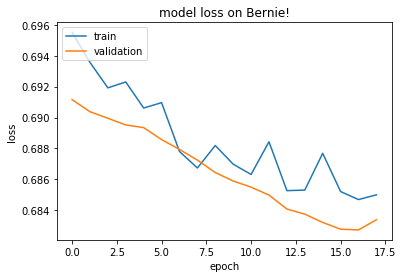

In [21]:
plot(era_models[100][1])

In [22]:
%%time
#era_models[119]
# now do a bunch of predictions

XV = data.x[ data.region=='validation' ]
YV = data.y[3][data.region=='validation']

# which era model to use per sample
M = np.argmax( model_dense.predict( data.x[ data.region=='validation' ] ), axis=1 )


In [149]:
from sklearn.metrics import log_loss


In [152]:
%%time

# precompute predictions + losses for every example in the validation set for all eras
# seems inefficient but due to vectorization of prediction this is likely much faster
# seems to take about 6 seconds per era for 56084 signals in validation

num_val = XV.shape[0]
num_eras = len(era_models)
era_preds = np.zeros( (num_val, num_eras ) )

for era in range(num_eras):
    
    preds = era_models[era][0].predict( XV ).reshape(-1)
    
    era_preds[:, era] = preds
    
    print('computed era: %d' % era )
    

computed era: 0
computed era: 1
computed era: 2
computed era: 3
computed era: 4
computed era: 5
computed era: 6
computed era: 7
computed era: 8
computed era: 9
computed era: 10
computed era: 11
computed era: 12
computed era: 13
computed era: 14
computed era: 15
computed era: 16
computed era: 17
computed era: 18
computed era: 19
computed era: 20
computed era: 21
computed era: 22
computed era: 23
computed era: 24
computed era: 25
computed era: 26
computed era: 27
computed era: 28
computed era: 29
computed era: 30
computed era: 31
computed era: 32
computed era: 33
computed era: 34
computed era: 35
computed era: 36
computed era: 37
computed era: 38
computed era: 39
computed era: 40
computed era: 41
computed era: 42
computed era: 43
computed era: 44
computed era: 45
computed era: 46
computed era: 47
computed era: 48
computed era: 49
computed era: 50
computed era: 51
computed era: 52
computed era: 53
computed era: 54
computed era: 55
computed era: 56
computed era: 57
computed era: 58
compute

In [148]:
logloss(YV, era_preds[:,0], eps=1e-15)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [156]:
%%time

best_preds = era_preds[ list(range(era_preds.shape[0])), list(M-1)]

# calculate loss from the best PREDICTED era model

losses = log_loss( YV, best_preds )

np.mean(losses)

0.6962326294957993

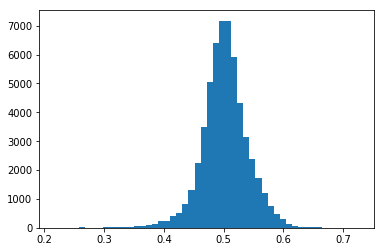

In [168]:
x=pyplot.hist(best_preds, bins=50)

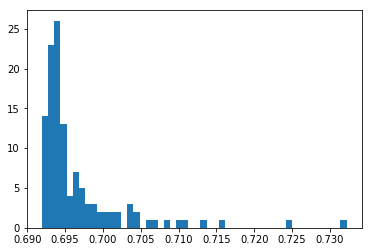

In [178]:
# what about taking all random preds from all eras, we expect this to be worse

era_losses = range(120) \
    |  select( lambda e: log_loss( YV, era_preds[:,e] ) ) \
    |  select( lambda e: np.mean(e) ) \
    |  as_list()

x=pyplot.hist(era_losses, bins=50)

In [217]:
%%time

# compute squared deviations
sqlosses = np.power( era_preds - np.transpose( np.tile(YV, (120,1)) ), 2 )

# which ones are the lowest per example?
best_actual = np.argmin(sqlosses, axis=1)

best_preds_actual = era_preds[ list(range(era_preds.shape[0])), list(best_actual)]

# calculate loss from the best PREDICTED era model
losses = log_loss( YV, best_preds_actual )

print( losses )

0.4517104292358132
Wall time: 399 ms


array([111,  43, 117, ...,  43, 109,  18], dtype=int64)

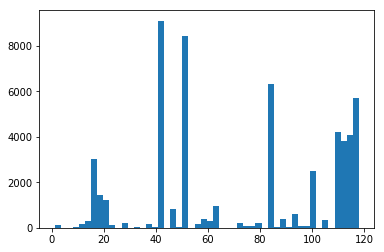

In [218]:
# visualising the actual regionality of eras, we see that validation looks a lot like
# later eras in validation, suggesting that its a continuation, which we know to be true
# can we say the same for live though? we have no labels there!

x=pyplot.hist(best_actual, bins=50)

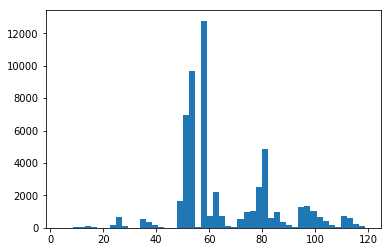

In [219]:
# there is similar regionality on the predicted best era models 
# so we can tell that the data is in era order, but unfortunatley
# it also shows us that our era prediction is comically poor!

x=pyplot.hist(M-1, bins=50)

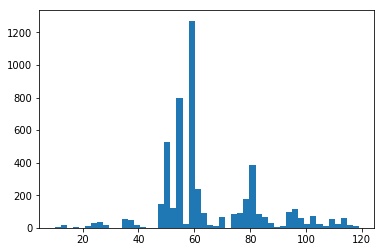

In [221]:
# lets try this on the live dataset

# which era model to use per sample
M = np.argmax( model_dense.predict( data.x[ data.region=='live' ] ), axis=1 )
x=pyplot.hist(M-1, bins=50)